## Project name: PY sales optimizer
## Consolidation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
import statsmodels.api
import statsmodels.formula.api as smf
from scipy import stats
from scipy.spatial.distance import cdist
#from yellowbrick.cluster import SilhouetteVisualizer


from sklearn.pipeline import make_pipeline

seed = 100

df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pakistan Largest Ecommerce Dataset.csv");

## Main results for Chapter 1: Data Description


In [ ]:
df.head()

item_id          status created_at  \
0  211131.0        complete   7/1/2016   
1  211133.0        canceled   7/1/2016   
2  211134.0        canceled   7/1/2016   
3  211135.0        complete   7/1/2016   
4  211136.0  order_refunded   7/1/2016   

                                                 sku   price  qty_ordered  \
0                                  kreations_YI 06-L  1950.0          1.0   
1  kcc_Buy 2 Frey Air Freshener & Get 1 Kasual Bo...   240.0          1.0   
2                                 Ego_UP0017-999-MR0  2450.0          1.0   
3                                     kcc_krone deal   360.0          1.0   
4                                        BK7010400AG   555.0          2.0   

   grand_total increment_id    category_name_1 sales_commission_code  ...  \
0       1950.0    100147443    Women's Fashion                    \N  ...   
1        240.0    100147444  Beauty & Grooming                    \N  ...   
2       2450.0    100147445    Women's Fashion                    \N  ...   
3         60.0    100147446  Beauty & Grooming           R-FSD-52352  ...   
4       1110.0    100147447            Soghaat                    \N  ...   

   Month Customer Since     M-Y    FY Customer ID  Unnamed: 21  Unnamed: 22  \
0    7.0         2016-7  7-2016  FY17         1.0          NaN          NaN   
1    7.0         2016-7  7-2016  FY17         2.0          NaN          NaN   
2    7.0         2016-7  7-2016  FY17         3.0          NaN          NaN   
3    7.0         2016-7  7-2016  FY17         4.0          NaN          NaN   
4    7.0         2016-7  7-2016  FY17         5.0          NaN          NaN   

  Unnamed: 23 Unnamed: 24 Unnamed: 25  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN  

[5 rows x 26 columns]

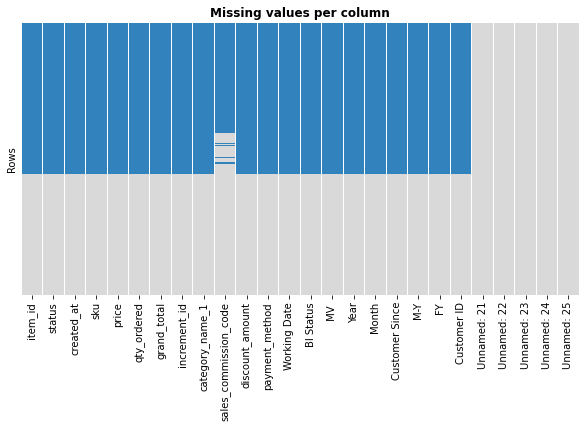

In [17]:
# Overview: Missing values
#df.info()
plt.figure(figsize=(10,5))
#sns.color_palette()
from matplotlib import cm

tab20c = cm.get_cmap('tab20c', 2)


#sns.set_palette("light:#5A9")

#sns.heatmap(df.isnull(),yticklabels=True,cbar=False, cmap='Paired')
#plt.legend(['Values', 'NAN'], loc='best')
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap=tab20c)
plt.title("Missing values per column", fontweight='bold')

plt.ylabel("Rows");

In [5]:
#Drop empty rows and columns
df.dropna(axis=0,how='all',inplace=True)
df.dropna(axis=1,how='all',inplace=True)
df.isna().sum(axis=0)


item_id                       0
status                       15
created_at                    0
sku                          20
price                         0
qty_ordered                   0
grand_total                   0
increment_id                  0
category_name_1             164
sales_commission_code    137175
discount_amount               0
payment_method                0
Working Date                  0
BI Status                     0
 MV                           0
Year                          0
Month                         0
Customer Since               11
M-Y                           0
FY                            0
Customer ID                  11
dtype: int64

In [6]:
#Sales_commission_code
df["sales_commission_code"].value_counts(normalize=True)

\N                0.757800
40968             0.006058
C-LHW-50074       0.005441
C-RWP-31924       0.003845
cisb30211         0.003606
                    ...   
100278139         0.000002
rwp-wah-104124    0.000002
C-FSD-42199       0.000002
Cfsd43702         0.000002
C LHE 45016       0.000002
Name: sales_commission_code, Length: 7226, dtype: float64

In [7]:
#Drop sales_commission_code
df=df.drop(["sales_commission_code"],axis=1)

# Delete rows with remaining "na" 
df=df.dropna(axis=0,how="any")

In [8]:
# Test duplicates
print(df.shape)
df[df.duplicated()==True].index

(584314, 20)


Int64Index([], dtype='int64')

In [7]:
#Extrem values
df[["price","qty_ordered","grand_total","discount_amount"]].describe()

price    qty_ordered   grand_total  discount_amount
count  5.843140e+05  584314.000000  5.843140e+05    584314.000000
mean   6.350766e+03       1.294308  8.532892e+03       499.655327
std    1.495150e+04       3.988150  6.133168e+04      1507.185808
min    0.000000e+00       1.000000 -1.594000e+03      -599.500000
25%    3.600000e+02       1.000000  9.452000e+02         0.000000
50%    8.994000e+02       1.000000  1.961000e+03         0.000000
75%    4.090000e+03       1.000000  6.999000e+03       160.734400
max    1.012626e+06    1000.000000  1.788800e+07     90300.000000

## Main results for Chapter 2: Data Exploration

In [9]:
# amount of orders
gd1=df.groupby(["increment_id"]).agg({"item_id":"count"})
print(len(gd1))

gd1["item_id"].value_counts(normalize=True).sort_index()

408659


1     0.799789
2     0.107344
3     0.043359
4     0.021397
5     0.010894
6     0.005973
7     0.003580
8     0.002349
9     0.001471
10    0.001013
11    0.000695
12    0.000568
13    0.000306
14    0.000237
15    0.000184
16    0.000171
17    0.000120
18    0.000083
19    0.000105
20    0.000061
21    0.000061
22    0.000024
23    0.000032
24    0.000024
25    0.000024
26    0.000015
27    0.000029
28    0.000010
29    0.000007
30    0.000010
31    0.000005
32    0.000005
33    0.000005
34    0.000010
36    0.000002
37    0.000005
38    0.000007
39    0.000002
40    0.000010
41    0.000002
43    0.000002
45    0.000002
47    0.000002
72    0.000002
Name: item_id, dtype: float64

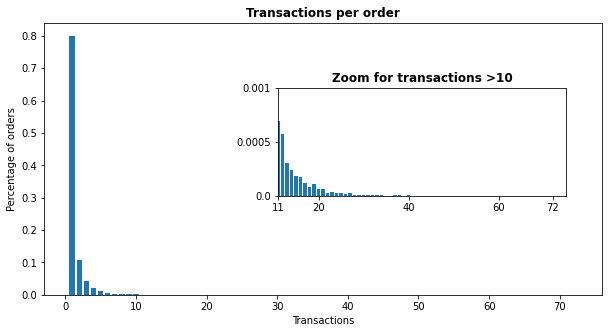

In [8]:
#barplot distribution
fp1=gd1["item_id"].value_counts(normalize=True).sort_index()
plt.figure(figsize=(10,5))
plt.bar(fp1.index,fp1.values)
plt.title("Transactions per order", fontweight="bold")
plt.xlabel("Transactions")
plt.ylabel("Percentage of orders")
plt.axes([0.45,0.4,0.4,0.3],facecolor="white")
plt.bar(fp1.index,fp1.values)
plt.xlim([11,75])
plt.ylim([0,0.001])
plt.yticks([0.000,0.0005,0.001],[0.000,0.0005,0.001])
plt.xticks([11,20,40,60,72],[11,20,40,60,72])
plt.title("Zoom for transactions >10", fontweight="bold");


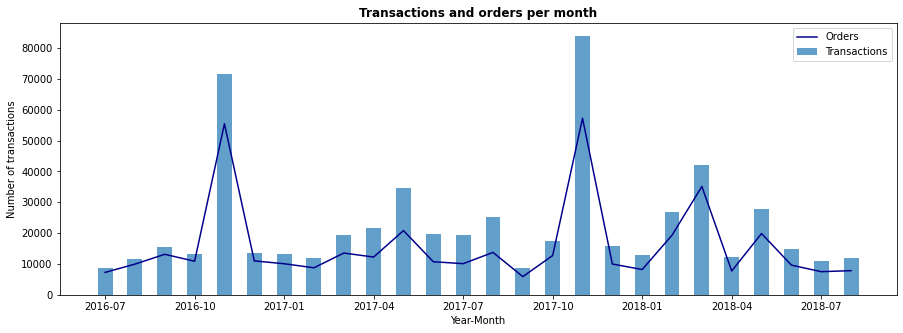

In [10]:
# Transactions per month
df["my"]=pd.to_datetime(df["M-Y"])
df["my"]=df["my"].dt.date.apply(lambda x: x.strftime('%Y-%m'))
my2=df["my"].value_counts().sort_index()
ticks=my2.index[range(0,26,3)].astype("str")

dg2=df.groupby(["increment_id"]).agg({"my":"max"})
my3=dg2["my"].value_counts().sort_index()

plt.figure(figsize=(15,5))
#plt.bar(range(0,26),my2.values,width=0.5,alpha=0.3,label="Transactions")
plt.bar(range(0,26),my2.values,width=0.5,alpha=0.7, label="Transactions")
plt.xticks(range(0,26,3),ticks)
plt.title("Transactions and orders per month",  fontweight="bold")
plt.xlabel("Year-Month")
plt.ylabel("Number of transactions")
plt.plot(range(0,26),my3.values,label="Orders", color='darkblue')
plt.legend();


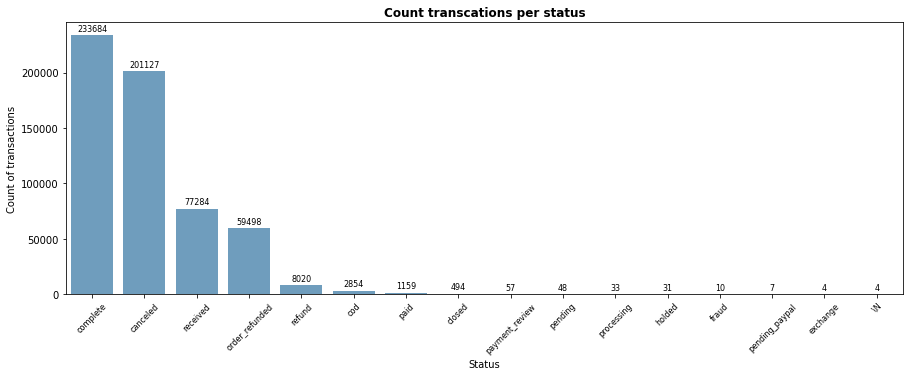

In [11]:
# Status overview 
len(df[(df["status"]=="complete") | (df["status"]=="canceled")])/len(df)
len(df[(df["status"]=="complete")])/len(df)
len(df[(df["status"]=="canceled")])/len(df)

fig, ax1 = plt.subplots(figsize=(15,5))
graph=sns.countplot(ax=ax1, x=df["status"], order=df['status'].value_counts(ascending=False).index, color='#629FCA')
plt.xticks(fontsize=8,rotation=45)
plt.ylabel('Count of transactions')
plt.xlabel('Status')
plt.title("Count transcations per status", fontweight='bold');
for p in graph.patches:
    height = p.get_height()
    plt.text(p.get_x()+p.get_width()/2., height + 4000,height,ha="center",fontsize=8)

In [12]:
#Grouping of status
df['status_new'] = df['status']
df['status_new'] = df['status_new'].replace(['order_refunded', 'refund'],'refunded')
df['status_new'] = df['status_new'].replace(['complete', 'closed'],'completed')
df['status_new'] = df['status_new'].replace(['paid','received','cod',"exchange"],'processing')
df['status_new'] = df['status_new'].replace(['holded','pending_paypal','payment_review'],'pending')

In [13]:
# Cases where grand_total formula fails
df['grand_item']=df["price"]*df["qty_ordered"] - df["discount_amount"]
test=df.groupby(["increment_id"]).agg({"grand_item":"sum","grand_total":"mean","item_id":"count"})
print(len(test[test["grand_item"] - test["grand_total"]==0])/len(test))

df[df["increment_id"]==100147663].iloc[:,0:12]

0.7991919913668853


item_id    status created_at  \
284  211442.0  complete   7/1/2016   
285  211443.0  complete   7/1/2016   
286  211444.0  complete   7/1/2016   
287  211445.0  complete   7/1/2016   
288  211446.0  complete   7/1/2016   
289  211447.0  complete   7/1/2016   

                                                   sku   price  qty_ordered  \
284                                        mm_AG-1038c  1690.0          1.0   
285                                     3m_DC272923871   500.0          1.0   
286                                     MEGUIAR_G12711  2800.0          1.0   
287                                      MEGUIAR_G3503  2550.0          1.0   
288                                      MEGUIAR_X3070   570.0          1.0   
289  BFk_Denim Jeans with Gallace for Boys |OF67-3-...   903.0          1.0   

     grand_total increment_id category_name_1  discount_amount payment_method  \
284       1013.0    100147663      Appliances              0.0            cod   
285       1013.0    100147663      Superstore              0.0            cod   
286       1013.0    100147663          Others              0.0            cod   
287       1013.0    100147663          Others              0.0            cod   
288       1013.0    100147663          Others              0.0            cod   
289       1013.0    100147663     Kids & Baby              0.0            cod   

    Working Date  
284     7/1/2016  
285     7/1/2016  
286     7/1/2016  
287     7/1/2016  
288     7/1/2016  
289     7/1/2016

In [14]:
# Data cleaning for  grand_total, price, discount_amount
df=df[df["price"]>0]
df=df[df["grand_total"]>0]
df=df[df["discount_amount"]>=0]

test=df.groupby(["increment_id"]).agg({"grand_item":"sum","grand_total":"mean","item_id":"count"})

test2=test[test["grand_item"] - test["grand_total"]==0]

dele=[]
for incid in df["increment_id"]:
  dele.append(incid in test2.index)

dft=df.loc[dele]
df=dft


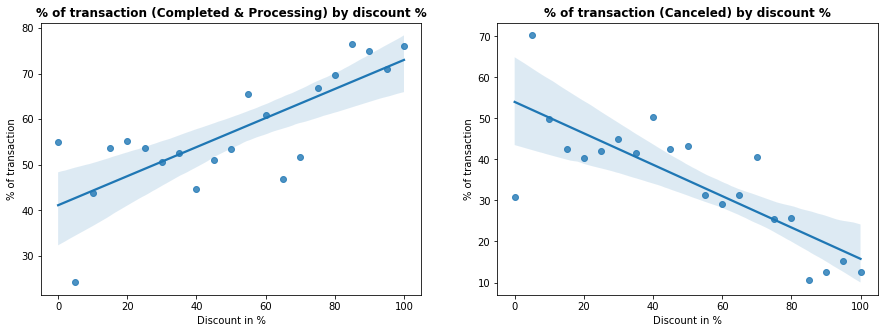

In [15]:
# Introducing new variables
df['discount_rate'] = (df['discount_amount']/(df["price"]*df["qty_ordered"])* 100).round(2)

df2=df
df2['discount_group'] = pd.cut(df2["discount_rate"],bins=[-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
                              labels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])

disc_status = (100*df2.groupby(['discount_group','status_new'])['status_new'].count() / df2.groupby(['discount_group'])['status_new'].count()).rename("ratio").reset_index()
disc_status['discount_group'] = disc_status.discount_group.astype('int')
fig_data1=disc_status[(disc_status.status_new=='completed')|(disc_status.status_new=='processing')]
fig_data1=fig_data1.groupby(['discount_group'])['ratio'].sum().reset_index()
fig_data2=disc_status[(disc_status.status_new=='canceled')]

plt.figure(figsize=(15,5))
plt.subplot(121)
sns.regplot(x='discount_group',y='ratio',data=fig_data1)
plt.ylabel('% of transaction')
plt.xlabel('Discount in %')
plt.title('% of transaction (Completed & Processing) by discount %', fontweight='bold')
plt.subplot(122)
sns.regplot(x='discount_group',y='ratio',data=fig_data2)
plt.ylabel('% of transaction')
plt.xlabel('Discount in %')
plt.title('% of transaction (Canceled) by discount %', fontweight='bold')
plt.show()

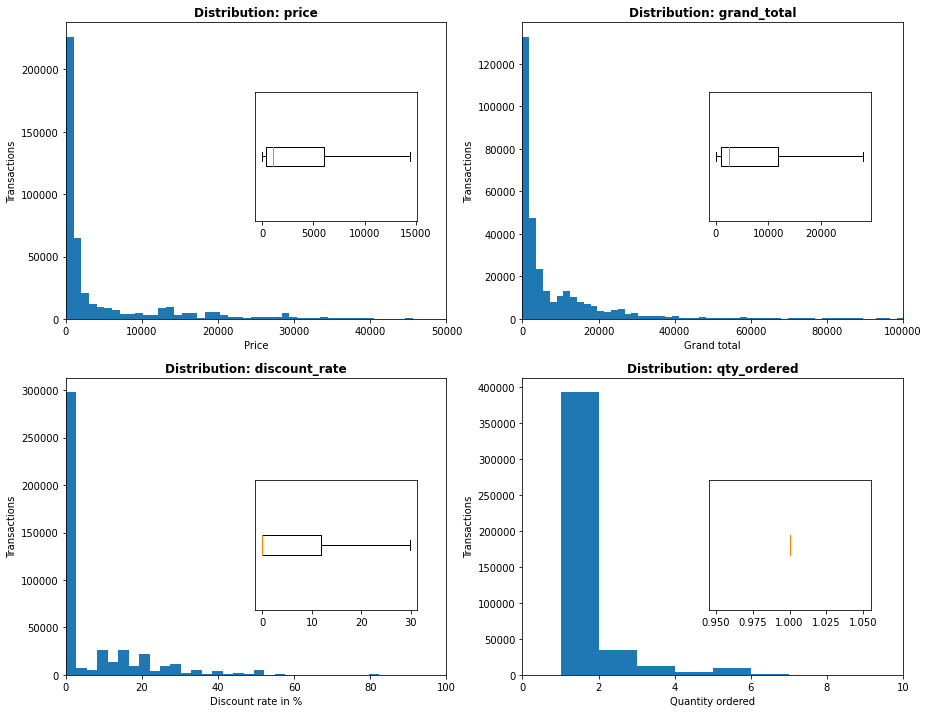

In [14]:
#Distribution of financial variables
Gt=df.groupby(["increment_id"]).agg({"grand_total":"mean"})

plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.hist(df["price"],bins=1000);
plt.title("Distribution: price", fontweight='bold')
plt.xlim([0,50000])
plt.xlabel('Price')
plt.ylabel('Transactions')
plt.axes([0.3,0.65,0.15,0.15],facecolor="white")
plt.boxplot(df["price"],showfliers=False, vert=False)
plt.yticks([])

plt.subplot(2,2,2)
plt.hist(Gt["grand_total"],bins=10000);
plt.title("Distribution: grand_total",fontweight='bold')
plt.xlim([0,100000])
plt.xlabel('Grand total')
plt.ylabel('Transactions')
plt.axes([0.72,0.65,0.15,0.15],facecolor="white")
plt.boxplot(Gt["grand_total"],showfliers=False, vert=False)
plt.yticks([])


plt.subplot(2,2,3)
plt.hist(df["discount_rate"],bins=200);
plt.title("Distribution: discount_rate",fontweight='bold')
plt.xlim([0,100])
plt.xlabel('Discount rate in %')
plt.ylabel('Transactions')
plt.axes([0.3,0.2,0.15,0.15],facecolor="white")
plt.boxplot(df["discount_rate"],showfliers=False, vert=False)
plt.yticks([])


plt.subplot(2,2,4)
plt.hist(df["qty_ordered"],bins=1000);
plt.title("Distribution: qty_ordered",fontweight='bold')
plt.xlim([0,10])
plt.xlabel('Quantity ordered')
plt.ylabel('Transactions')
plt.axes([0.72,0.2,0.15,0.15],facecolor="white")
plt.boxplot(df["qty_ordered"],showfliers=False, vert=False)
plt.yticks([]);


In [16]:
df.category_name_1.fillna('\\N',inplace=True)
df.category_name_1.replace('\\N',"Others",inplace=True)

test= pd.DataFrame(df["category_name_1"].value_counts())
test=test.reset_index()

import matplotlib

cmap = matplotlib.cm.Blues
mini=min(test['category_name_1'])
maxi=max(test['category_name_1'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in test['category_name_1']]

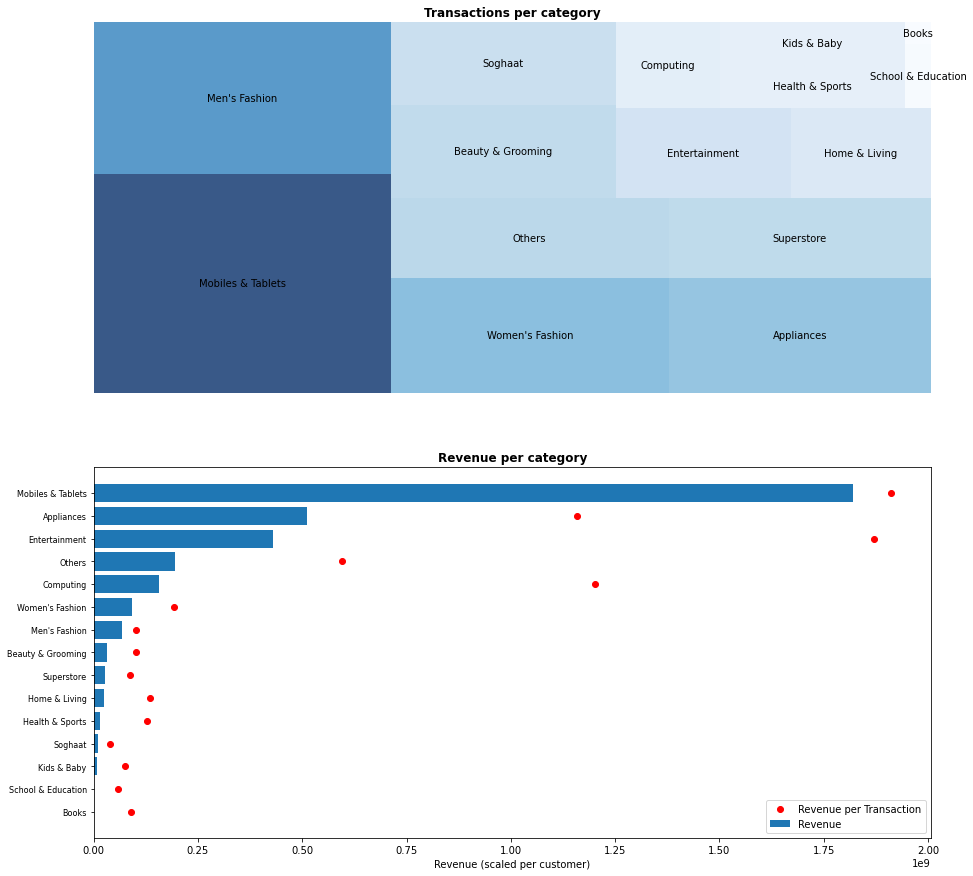

In [17]:
# Categories and Revenue
!pip install squarify
import squarify


df.category_name_1.fillna('\\N',inplace=True)
df.category_name_1.replace('\\N',"Others",inplace=True)

test= pd.DataFrame(df["category_name_1"].value_counts())
test=test.reset_index()
test

test.head()

rev=df.groupby(["category_name_1"]).agg({"grand_item":"sum"}).sort_values(by=["grand_item"],ascending=True)
rev2=df.groupby(["category_name_1"]).agg({"grand_item":"sum","item_id":"count"}).sort_values(by=["grand_item"],ascending=True)
rel=rev2["grand_item"]/rev2["item_id"]*100000

cmap = matplotlib.cm.Blues
mini=min(test['category_name_1'])
maxi=max(test['category_name_1'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in test['category_name_1']]


plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
squarify.plot(sizes=test["category_name_1"], label=test["index"], alpha=0.8 , color=colors)
plt.axis('off')
plt.title("Transactions per category", fontweight='bold')

plt.subplot(2,1,2)
plt.barh(range(len(rev)),rev.values.reshape((15,)), label="Revenue")
plt.yticks(range(len(rev)),rev.index,fontsize=8)
plt.title("Revenue per category", fontweight='bold')
plt.xlabel('Revenue (scaled per customer)')
plt.scatter(rel.values,range(len(rev)),color="red",label="Revenue per Transaction")
plt.legend();

In [18]:
# Transactions per customer: Facts
df["category_name_1"].value_counts(normalize=True)

Mobiles & Tablets     0.209545
Men's Fashion         0.145229
Women's Fashion       0.103222
Appliances            0.096967
Others                0.072043
Superstore            0.067873
Beauty & Grooming     0.067312
Soghaat               0.059917
Entertainment         0.050683
Home & Living         0.040471
Computing             0.028649
Health & Sports       0.025725
Kids & Baby           0.025389
School & Education    0.005217
Books                 0.001758
Name: category_name_1, dtype: float64

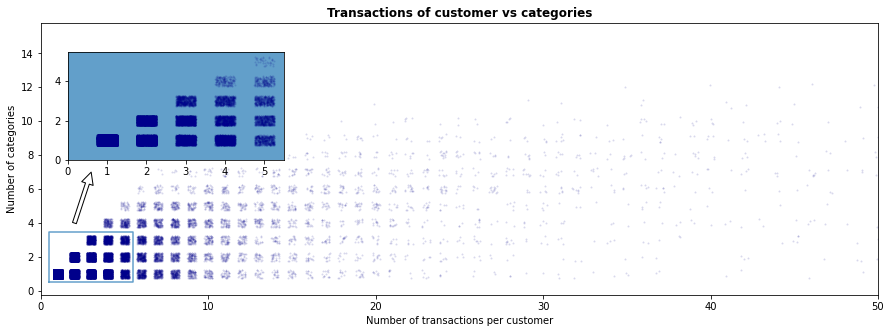

In [19]:
# Transactions per customer 

def func (x):
  return len(np.unique(x))
test=df[df["status_new"]=="completed"]

a=test.groupby("Customer ID").agg({"item_id" : "count", "category_name_1":func})
v=np.arange(-0.25,0.25,0.001)
w=np.arange(-0.25,0.25,0.001)
b=np.random.choice(v,len(a))
e=np.random.choice(w,len(a))
c=a["category_name_1"]+b
d=a["item_id"]+e

plt.figure(figsize=(15,5))
plt.scatter(d,c,s=2,alpha=0.1,marker="*",color="darkblue")
plt.annotate("",xy=(3,7),xytext=(2,4),arrowprops={"facecolor":"white"})
plt.xlim([0,50])
plt.xlabel("Number of transactions per customer")
plt.ylabel("Number of categories")
plt.title("Transactions of customer vs categories", fontweight='bold')
plt.plot([0.5,0.5,5.5,5.5,0.5],[0.5,3.5,3.5,0.5,0.5],"#629FCA")
plt.axes([0.15,0.5,0.2,0.3],facecolor="#629FCA")
plt.scatter(d,c,s=2,alpha=0.1,marker="*",color="darkblue")
plt.xlim([0,5.5])
plt.ylim([0,5.5]);

In [20]:
# Blue box
len(a[(a["item_id"]<5)&(a["category_name_1"]<5)])/len(a)

0.8541049394291715

In [18]:
# Further feature engeneering not mentioned explizitly  in report
df["BI Status"]=df["BI Status"].replace(to_replace=['#REF!'],value=["Net"])
df['BIstatus_num'] = df['BI Status']
df['BIstatus_num'] = df['BIstatus_num'].replace(['Net'], 1)
df['BIstatus_num'] = df['BIstatus_num'].replace(['Valid'], 0)
df['BIstatus_num'] = df['BIstatus_num'].replace(['Gross'], -1)

df['status_new'] = df['status']
df['status_new'] = df['status_new'].replace(['order_refunded', 'refund'],'refunded')
df['status_new'] = df['status_new'].replace(['complete', 'closed'],'completed')
df['status_new'] = df['status_new'].replace(['paid','received','cod',"exchange"],'processing')
df['status_new'] = df['status_new'].replace(['holded','pending_paypal','payment_review'],'pending')

df['payment_method'].replace(['Easypay_MA','easypay_voucher'],'Easypay',inplace=True)
df['payment_method'].replace(['jazzwallet','jazzvoucher'],'Jazz',inplace=True)
df['payment_method'].replace(['customercredit','ublcreditcard'],'Credit',inplace=True)
df['payment_method'].replace(['internetbanking'],'bankalfalah',inplace=True)

In [19]:
# New variable of special intrest: Lifetime
df['Working Date2'] = pd.to_datetime(df['Working Date'])
base = df['Working Date2'].max()
df['Date'] = df['Working Date2'].apply(lambda x: x.date())
df['Customer_Since_Date'] = df.groupby('Customer ID')['Date'].transform(min)
df['Lifetime'] = (base.date() - df['Customer_Since_Date']).astype('timedelta64[D]') + 1

In [21]:
#most recent date
base

Timestamp('2018-08-16 00:00:00')

## RFM segmentation

In [20]:
#Only focus on positive/"promissing" transactions 
df=df[(df["status_new"]=="completed")|(df["status_new"]=="processing")]
print("Z score = (x-mean)/standard deviation = 3, gives 99.7% of the data points lie between +/- standard deviation. We use this statistics concept to remove outliers!")

Z score = (x-mean)/standard deviation = 3, gives 99.7% of the data points lie between +/- standard deviation. We use this statistics concept to remove outliers!


In [21]:
#Delete outliers in attributes relevant for RFM-score calculation

#Number of orders (for Frequency)
T1=df.groupby(["Customer ID"]).agg({"increment_id":"count"})
m1=T1["increment_id"].mean()
s1=T1["increment_id"].std()
A1=T1[T1["increment_id"]<=m1+3*s1]
a1=A1.index
lis=[]
for id in df["Customer ID"]:
  lis.append(id in a1)

df1=df.iloc[lis]


# price, qty_ordered, discount_rate (for Monetary)
zpmax=df["price"].mean()+3*df["price"].std()
zpmin=df["price"].mean()-3*df["price"].std()
data=df1[(df1["price"]>=zpmin) & (df1["price"]<=zpmax)]

zqmax=data["qty_ordered"].mean()+3*data["qty_ordered"].std()
zqmin=data["qty_ordered"].mean()-3*data["qty_ordered"].std()
data=data[(data["qty_ordered"]>=zqmin) & (data["qty_ordered"]<=zqmax)]

zdmax=data["discount_rate"].mean()+3*data["discount_rate"].std()
zdmin=data["discount_rate"].mean()-3*data["discount_rate"].std()
data=data[(data["discount_rate"]>=zdmin) & (data["discount_rate"]<=zdmax)]

In [22]:
# Calculate RFM-scores:
# Absolute table
# Recency: Days since last purchase

data['Working Date'] = pd.to_datetime(data['Working Date'])
base = data['Working Date'].max()
data['Date'] = data['Working Date'].apply(lambda x: x.date())
data['Most_Recent_Purchase'] = data.groupby('Customer ID')['Date'].transform(max)
data['Recency'] = (base.date() - data['Most_Recent_Purchase']).astype('timedelta64[D]')

# Frequency: Total number of purchases
data['Frequency'] = data.groupby('Customer ID')['increment_id'].transform('nunique')

# Monetary: Total amount spend
data['Monetary'] = data.groupby('Customer ID')['grand_item'].transform('sum')

#RFM table
RFM_abs= data[['Customer ID', 'Recency', 'Frequency', 'Monetary']].drop_duplicates()
RFM_plot=RFM_abs.set_index("Customer ID")
RFM_plot.loc[[1,6,9,10,28910]]

Recency  Frequency  Monetary
Customer ID                              
1              739.0          1    1950.0
6              739.0          1     170.0
9              739.0          1    5500.0
10             739.0          1     366.0
28910          571.0          1     388.0

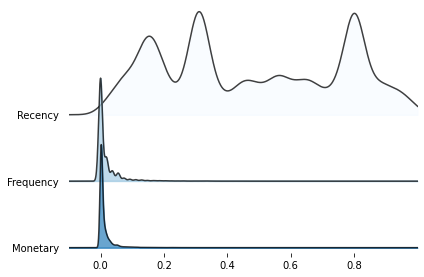

In [26]:
#distributions:
!pip install joypy
import joypy
from matplotlib import cm

#Absolut / Frequency
RFM_neu=RFM_abs.copy()
RFM_neu["Recency"]=(RFM_neu["Recency"]-RFM_neu["Recency"].min())/(RFM_neu["Recency"].max()-RFM_neu["Recency"].min())
RFM_neu["Frequency"]=(RFM_neu["Frequency"]-RFM_neu["Frequency"].min())/(RFM_neu["Frequency"].max()-RFM_neu["Frequency"].min())
RFM_neu["Monetary"]=(RFM_neu["Monetary"]-RFM_neu["Monetary"].min())/(RFM_neu["Monetary"].max()-RFM_neu["Monetary"].min())
fig, axes = joypy.joyplot([RFM_neu["Recency"],RFM_neu["Frequency"],RFM_neu["Monetary"]], ylim="own", x_range=(-0.1,1), legend=True,  labels=['Recency', 'Frequency', 'Monetary'], colormap=cm.Blues, alpha=.75, figsize=(6,4))
#plt.title('RFM Distribution based on scaled absolut values', fontweight='bold')




In [27]:
#RFM table relative
data['Working Date3'] = pd.to_datetime(data['Working Date'])
base = data['Working Date3'].max()
data['Date'] = data['Working Date3'].apply(lambda x: x.date())
data['Customer_Since_Date'] = data.groupby('Customer ID')['Date'].transform(min)
data['Lifetime'] = (base.date() - data['Customer_Since_Date']).astype('timedelta64[D]') + 1

data['Rel. Frequency'] = data['Frequency'] / (data['Lifetime']) * 100
RFM_rel= data[['Customer ID', 'Recency', 'Rel. Frequency', 'Monetary']].drop_duplicates()
RFM_plot2=RFM_rel.set_index("Customer ID")
RFM_plot2.loc[[1,6,9,10,28910]]


Recency  Rel. Frequency  Monetary
Customer ID                                   
1              739.0        0.135135    1950.0
6              739.0        0.135135     170.0
9              739.0        0.135135    5500.0
10             739.0        0.135135     366.0
28910          571.0        0.174825     388.0

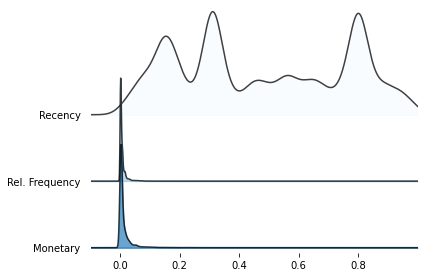

In [28]:
#Absolut / Rel. Frequency
RFM_neu=RFM_rel.copy()
RFM_neu["Recency"]=(RFM_neu["Recency"]-RFM_neu["Recency"].min())/(RFM_neu["Recency"].max()-RFM_neu["Recency"].min())
RFM_neu["Rel. Frequency"]=(RFM_neu["Rel. Frequency"]-RFM_neu["Rel. Frequency"].min())/(RFM_neu["Rel. Frequency"].max()-RFM_neu["Rel. Frequency"].min())
RFM_neu["Monetary"]=(RFM_neu["Monetary"]-RFM_neu["Monetary"].min())/(RFM_neu["Monetary"].max()-RFM_neu["Monetary"].min())
fig, axes = joypy.joyplot([RFM_neu["Recency"],RFM_neu["Rel. Frequency"],RFM_neu["Monetary"]], ylim="own", x_range=(-0.1,1), labels=['Recency', 'Rel. Frequency', 'Monetary'], colormap=cm.Blues, alpha=.75,  figsize=(6,4))


In [29]:
#RFM table frequency score
RFM_score_abs=RFM_abs.copy()
RFM_score_abs["Recency"]=pd.qcut(RFM_score_abs["Recency"],5,labels=[5,4,3,2,1])
RFM_abs["Frequency"][RFM_abs["Frequency"]!=1].value_counts(normalize=True)
RFM_score_abs["Frequency"]=pd.cut(RFM_score_abs["Frequency"],bins=[0,1,2,3,6,60],labels=[1,2,3,4,5])
RFM_score_abs["Monetary"]=pd.qcut(RFM_score_abs["Monetary"],5,labels=[1,2,3,4,5])
RFM_score_abs_plot= RFM_score_abs.set_index("Customer ID")
RFM_score_abs_plot.loc[[1,6,9,10,28910]]

Recency Frequency Monetary
Customer ID                           
1                 1         1        2
6                 1         1        1
9                 1         1        4
10                1         1        1
28910             2         1        1

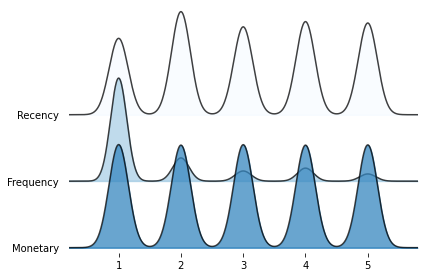

In [30]:
#Scores / Frequency
fig, axes = joypy.joyplot([RFM_score_abs["Recency"],RFM_score_abs["Frequency"],RFM_score_abs["Monetary"]],ylim="own" , labels=['Recency', 'Frequency', 'Monetary'], colormap=cm.Blues, alpha=.75,figsize=(6,4))

In [31]:
#RFM table score, rel. frequency
RFM_score_rel=RFM_rel.copy()
RFM_score_rel["Recency"]=pd.qcut(RFM_score_rel["Recency"],5,labels=[5,4,3,2,1])
RFM_score_rel["Rel. Frequency"]=pd.qcut(RFM_score_rel["Rel. Frequency"],5,labels=[1,2,3,4,5])
RFM_score_rel["Monetary"]=pd.qcut(RFM_score_rel["Monetary"],5,labels=[1,2,3,4,5])
RFM_score_rel_plot= RFM_score_rel.set_index("Customer ID")
RFM_score_rel_plot.loc[[1,6,9,10,28910]]

Recency Rel. Frequency Monetary
Customer ID                                
1                 1              1        2
6                 1              1        1
9                 1              1        4
10                1              1        1
28910             2              2        1

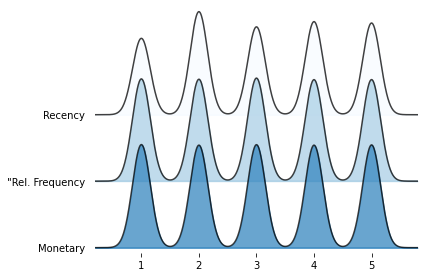

In [32]:
#Scores / Rel. Frequency
fig, axes = joypy.joyplot([RFM_score_rel["Recency"],RFM_score_rel["Rel. Frequency"],RFM_score_rel["Monetary"]],ylim="own", labels=['Recency', '"Rel. Frequency', 'Monetary'], colormap=cm.Blues, alpha=.75,figsize=(6,4))

In [33]:
#Distribution evaluation
len(RFM_abs[RFM_abs["Frequency"]<10000])/len(RFM_abs)
len(RFM_abs[RFM_abs["Monetary"]<10000])/len(RFM_abs)


0.7309845512304838

In [34]:
# Grouping according to introduction

RFM_base1=RFM_score_abs.copy()
RFM_base1["yvalue"]=RFM_base1["Recency"]

RFM_base1["Recency"]=RFM_base1["Recency"].astype("int")
RFM_base1["Frequency"] = RFM_base1["Frequency"].astype("int")
RFM_base1["Monetary"]= RFM_base1["Monetary"].astype("int")

RFM_base1["yvalue"]=RFM_base1["Recency"]

RFM_base1["yvalue"][(RFM_base1["Recency"]==1) & (RFM_base1["Monetary"]==1)]=1
RFM_base1["yvalue"][(RFM_base1["Recency"]==1) & (RFM_base1["Monetary"]==2)]=2
RFM_base1["yvalue"][(RFM_base1["Recency"]==1) & (RFM_base1["Monetary"]==3)]=3
RFM_base1["yvalue"][(RFM_base1["Recency"]==1) & (RFM_base1["Monetary"]==4)]=4
RFM_base1["yvalue"][(RFM_base1["Recency"]==1) & (RFM_base1["Monetary"]==5)]=5

RFM_base1["yvalue"][(RFM_base1["Recency"]==2) & (RFM_base1["Monetary"]==1)]=6
RFM_base1["yvalue"][(RFM_base1["Recency"]==2) & (RFM_base1["Monetary"]==2)]=7
RFM_base1["yvalue"][(RFM_base1["Recency"]==2) & (RFM_base1["Monetary"]==3)]=8
RFM_base1["yvalue"][(RFM_base1["Recency"]==2) & (RFM_base1["Monetary"]==4)]=9
RFM_base1["yvalue"][(RFM_base1["Recency"]==2) & (RFM_base1["Monetary"]==5)]=10

RFM_base1["yvalue"][(RFM_base1["Recency"]==3) & (RFM_base1["Monetary"]==1)]=11
RFM_base1["yvalue"][(RFM_base1["Recency"]==3) & (RFM_base1["Monetary"]==2)]=12
RFM_base1["yvalue"][(RFM_base1["Recency"]==3) & (RFM_base1["Monetary"]==3)]=13
RFM_base1["yvalue"][(RFM_base1["Recency"]==3) & (RFM_base1["Monetary"]==4)]=14
RFM_base1["yvalue"][(RFM_base1["Recency"]==3) & (RFM_base1["Monetary"]==5)]=15

RFM_base1["yvalue"][(RFM_base1["Recency"]==4) & (RFM_base1["Monetary"]==1)]=16
RFM_base1["yvalue"][(RFM_base1["Recency"]==4) & (RFM_base1["Monetary"]==2)]=17
RFM_base1["yvalue"][(RFM_base1["Recency"]==4) & (RFM_base1["Monetary"]==3)]=18
RFM_base1["yvalue"][(RFM_base1["Recency"]==4) & (RFM_base1["Monetary"]==4)]=19
RFM_base1["yvalue"][(RFM_base1["Recency"]==4) & (RFM_base1["Monetary"]==5)]=20

RFM_base1["yvalue"][(RFM_base1["Recency"]==5) & (RFM_base1["Monetary"]==1)]=21
RFM_base1["yvalue"][(RFM_base1["Recency"]==5) & (RFM_base1["Monetary"]==2)]=22
RFM_base1["yvalue"][(RFM_base1["Recency"]==5) & (RFM_base1["Monetary"]==3)]=23
RFM_base1["yvalue"][(RFM_base1["Recency"]==5) & (RFM_base1["Monetary"]==4)]=24
RFM_base1["yvalue"][(RFM_base1["Recency"]==5) & (RFM_base1["Monetary"]==5)]=25


In [35]:
#clustering
RFM_base1["Cluster"]=RFM_base1["Recency"]

RFM_base1["Cluster"][(RFM_base1["yvalue"]>0) & (RFM_base1["yvalue"]<=4) & (RFM_base1["Frequency"]>0) & (RFM_base1["Frequency"]<=1)]=1
RFM_base1["Cluster"][(RFM_base1["yvalue"]>4) & (RFM_base1["yvalue"]<=8) & (RFM_base1["Frequency"]>0) & (RFM_base1["Frequency"]<=1)]=2
RFM_base1["Cluster"][(RFM_base1["yvalue"]>0) & (RFM_base1["yvalue"]<=8) & (RFM_base1["Frequency"]>=2) & (RFM_base1["Frequency"]<=5)]=3
RFM_base1["Cluster"][(RFM_base1["yvalue"]>8) & (RFM_base1["yvalue"]<=25) & (RFM_base1["Frequency"]>=0) & (RFM_base1["Frequency"]<=1)]=4
RFM_base1["Cluster"][(RFM_base1["yvalue"]>8) & (RFM_base1["yvalue"]<=12) & (RFM_base1["Frequency"]>=2) & (RFM_base1["Frequency"]<=5)]=4
RFM_base1["Cluster"][(RFM_base1["yvalue"]>12) & (RFM_base1["yvalue"]<=17) & (RFM_base1["Frequency"]>=2) & (RFM_base1["Frequency"]<=5)]=5
RFM_base1["Cluster"][(RFM_base1["yvalue"]>17) & (RFM_base1["yvalue"]<=25) & (RFM_base1["Frequency"]>=2) & (RFM_base1["Frequency"]<=3)]=6
RFM_base1["Cluster"][(RFM_base1["yvalue"]>17) & (RFM_base1["yvalue"]<=19) & (RFM_base1["Frequency"]>=2) & (RFM_base1["Frequency"]<=5)]=6
RFM_base1["Cluster"][(RFM_base1["yvalue"]>19) & (RFM_base1["yvalue"]<=25) & (RFM_base1["Frequency"]>=4) & (RFM_base1["Frequency"]<=5)]=7

In [36]:
#statistics
print(len(RFM_base1[RFM_base1["Cluster"]==1])/len(RFM_base1)*100)
print(len(RFM_base1[RFM_base1["Cluster"]==2])/len(RFM_base1)*100)
print(len(RFM_base1[RFM_base1["Cluster"]==3])/len(RFM_base1)*100)
print(len(RFM_base1[RFM_base1["Cluster"]==4])/len(RFM_base1)*100)
print(len(RFM_base1[RFM_base1["Cluster"]==5])/len(RFM_base1)*100)
print(len(RFM_base1[RFM_base1["Cluster"]==6])/len(RFM_base1)*100)
print(len(RFM_base1[RFM_base1["Cluster"]==7])/len(RFM_base1)*100)

12.739899197189342
14.022097814844608
7.2105202672752045
42.02689169443943
6.355173942309271
10.372510712350808
7.272906371591338


In [37]:
#Recency average per cluster
print(RFM_abs[RFM_base1["Cluster"]==1]["Recency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==2]["Recency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==3]["Recency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==4]["Recency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==5]["Recency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==6]["Recency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==7]["Recency"].mean())

#Freqeuency average per cluster
print(RFM_abs[RFM_base1["Cluster"]==1]["Frequency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==2]["Frequency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==3]["Frequency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==4]["Frequency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==5]["Frequency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==6]["Frequency"].mean())
print(RFM_abs[RFM_base1["Cluster"]==7]["Frequency"].mean())

#Monetary average per cluster
print(RFM_abs[RFM_base1["Cluster"]==1]["Monetary"].mean())
print(RFM_abs[RFM_base1["Cluster"]==2]["Monetary"].mean())
print(RFM_abs[RFM_base1["Cluster"]==3]["Monetary"].mean())
print(RFM_abs[RFM_base1["Cluster"]==4]["Monetary"].mean())
print(RFM_abs[RFM_base1["Cluster"]==5]["Monetary"].mean())
print(RFM_abs[RFM_base1["Cluster"]==6]["Monetary"].mean())
print(RFM_abs[RFM_base1["Cluster"]==7]["Monetary"].mean())

639.4520618556701
544.5396323615502
578.3483606557377
256.81593030977774
320.46938775510205
150.2408990186768
134.78374717832958
1.0
1.0
2.894125683060109
1.2897378803859525
4.002066649444588
2.6049382716049383
7.621670428893905
2136.3958737113435
2932.25034744175
4390.044267987251
7230.628278010866
16760.939208705768
17323.35827268126
71580.05797589237


Text(0.5, 1.0, 'Baseline Segmentation')

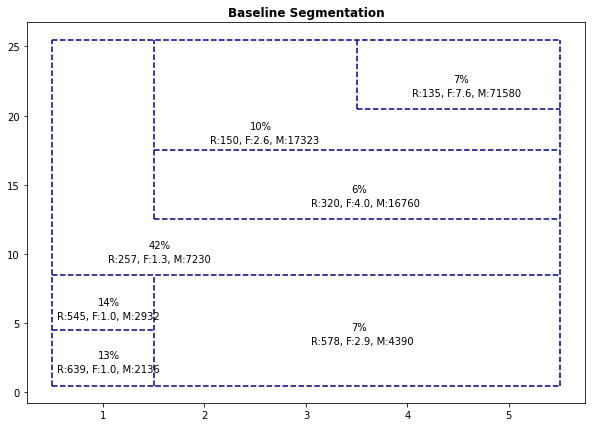

In [38]:
#segmentation
fig = plt.figure(figsize=(10,7))
plt.plot([0.5,1.5],[4.5,4.5],"--", color='#000080')
plt.plot([1.5,1.5],[0.5,8.5],"--", color='#000080')
plt.plot([0.5,5.5],[8.5,8.5],"--", color='#000080')
plt.plot([1.5,1.5],[12.5,25.5],"--", color='#000080')
plt.plot([1.5,5.5],[12.5,12.5],"--", color='#000080')
plt.plot([1.5,5.5],[17.5,17.5],"--", color='#000080')
plt.plot([3.5,5.5],[20.5,20.5],"--", color='#000080')
plt.plot([3.5,3.5],[20.5,25.5],"--", color='#000080')
plt.plot([0.5,0.5],[0.5,25.5],"--", color='#000080')
plt.plot([0.5,5.5],[0.5,0.5],"--", color='#000080')
plt.plot([0.5,5.5],[25.5,25.5],"--", color='#000080')
plt.plot([5.5,5.5],[0.5,25.5],"--", color='#000080')
plt.text(0.95,2.5,"13%")
plt.text(0.55,1.5,"R:639, F:1.0, M:2136")
plt.text(0.95,6.3,"14%")
plt.text(0.55,5.3,"R:545, F:1.0, M:2932")
plt.text(3.45,4.5,"7%")
plt.text(3.05,3.5,"R:578, F:2.9, M:4390")
plt.text(1.45,10.45,"42%")
plt.text(1.05,9.45,"R:257, F:1.3, M:7230")
plt.text(3.45,14.45,"6%")
plt.text(3.05,13.45,"R:320, F:4.0, M:16760")
plt.text(2.45,19,"10%")
plt.text(2.05,18,"R:150, F:2.6, M:17323")
plt.text(4.45,22.45,"7%")
plt.text(4.05,21.45,"R:135, F:7.6, M:71580");
plt.title('Baseline Segmentation', fontweight='bold')
#plt.axis('off')


In [39]:
from plotly.graph_objects import Layout
layout = Layout(plot_bgcolor='rgba(0,0,0,0)')


In [40]:
#evaluation
! pip install chart_studio
import chart_studio.plotly as py
import plotly.figure_factory as ff


x = RFM_base1["Frequency"]
y = RFM_base1["yvalue"]

#colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]

colorscale = ['#1F4E79', '#2E75B6', '#9DC3E6', (1, 1, 0.2), (0.98,0.98,0.98)]


fig = ff.create_2d_density(
    x, y, colorscale='Blues',
    #hist_color='grey',
     point_size=3

)
fig.update_layout(
    autosize=False,
    width=800,
    height=800, plot_bgcolor='rgba(0,0,0,0)', title='Name of Graph to be defined'   )
fig.show()



     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=96c7b8b71734ffbebd028a1e898b46515da1384499c39c3362d96096a90b8189
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [73]:
RFM_base1.describe()

Customer ID       Recency     Frequency      Monetary        yvalue  \
count   60911.000000  60911.000000  60911.000000  60911.000000  60911.000000   
mean    50233.723613      3.045755      1.714075      2.998769     13.227545   
std     32628.373730      1.385239      1.179187      1.414683      7.604244   
min         1.000000      1.000000      1.000000      1.000000      1.000000   
25%     20955.500000      2.000000      1.000000      2.000000      7.000000   
50%     47122.000000      3.000000      1.000000      3.000000     13.000000   
75%     78124.500000      4.000000      2.000000      4.000000     20.000000   
max    112161.000000      5.000000      5.000000      5.000000     25.000000   

            Cluster  
count  60911.000000  
mean       3.754445  
std        1.688888  
min        1.000000  
25%        2.000000  
50%        4.000000  
75%        4.000000  
max        7.000000

In [41]:
#silhouette score
RFM_sil=RFM_abs.drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM_sil)
RFM_sil=scaler.transform(RFM_sil)
RFM_sil2=pd.DataFrame(RFM_sil)
silhouette_score(RFM_sil2,RFM_base1["Cluster"],metric="sqeuclidean")

-0.16966796256864083

In [42]:
# Baseline Model 
RFM=RFM_abs.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)

In [ ]:
#########################
#Following code for each model individually

In [38]:
# Elbow 
range_n_cluster = [2,3,4,5,6,7,8,9,10,11,12]
ssd = []
distortions = []
for i in range_n_cluster:
    kmeans = KMeans(n_clusters = i, random_state=seed)
    kmeans.fit(RFM)
    ssd.append(kmeans.inertia_)
    distortions.append(sum(np.min(cdist(RFM, kmeans.cluster_centers_, 'euclidean'), axis=1)) / np.size(RFM, axis = 0))

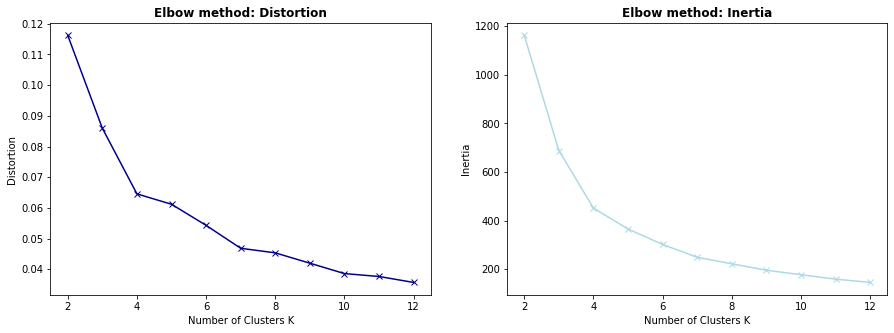

In [39]:
# Elbow: Plotting the distortion as a function of the number of clusters
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range_n_cluster, distortions, 'x-', color='darkblue')
plt.xlabel('Number of Clusters K')
plt.ylabel('Distortion')
plt.title('Elbow method: Distortion',fontweight='bold');

plt.subplot(1,2,2)
plt.plot(range_n_cluster, ssd, 'x-', color='lightblue')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('Elbow method: Inertia', fontweight='bold');

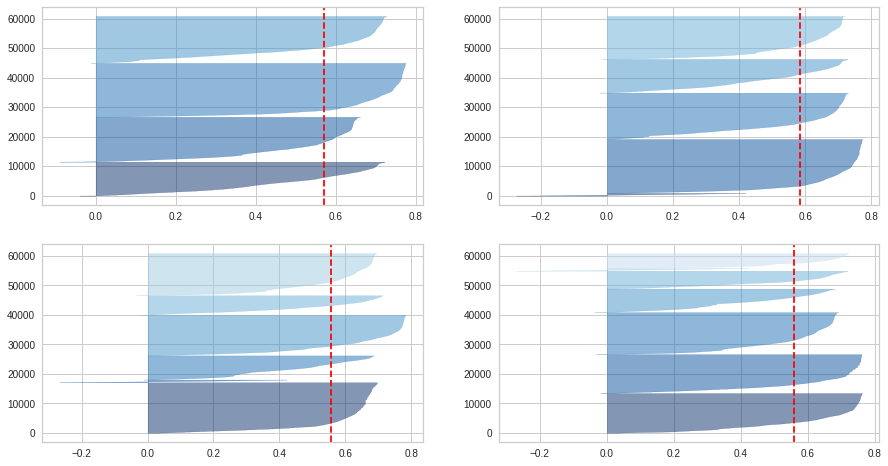

In [42]:
# Silhouette: Plotting the distortion as a function of the number of clusters

from yellowbrick.cluster import SilhouetteVisualizer

#colors = ['#08306B', '#2F5597', '#8FAADC', '#B4C7E7', '#DAE3F3', '#4472C4','#F4B183','#C55A11']

colors = ['#08306B', '#08519C', '#2171B5', '#4292C6', '#6BAED6', '#9ECAE1','#C6DBEF','#DEEBF7']

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [4, 5, 6, 7]:
    km = KMeans(n_clusters = i, n_init=10, max_iter=100, random_state=seed)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax[q-2][mod])
    visualizer.fit(RFM)

# note: this step takes about 30mins

In [43]:
#kmeans with 4 clusters 

kmeans=KMeans(n_clusters=4, random_state = seed)
kmeans.fit(RFM)
silhouette_score(RFM,kmeans.labels_,metric="sqeuclidean")

0.7093971922069029

In [44]:
RFM_res = RFM_abs.copy()
RFM_res['Cluster1'] = kmeans.labels_
RFM_res.head()

Customer ID  Recency  Frequency  Monetary  Cluster1
0           1.0    739.0          1    1950.0         2
7           6.0    739.0          1     170.0         2
10          9.0    739.0          1    5500.0         2
11         10.0    739.0          1     366.0         2
13         11.0    689.0          3     780.0         2

In [100]:
#3d plot

import plotly.express as px

RFMp=RFM_res.drop(["Cluster1"],axis=1)
colors = ['#08306B', '#08519C', '#2171B5', '#4292C6', '#6BAED6']
fig = px.scatter_3d(RFM_res, x="Frequency", y="Monetary", z="Recency",labels="Cluster1",  width=1000,
    height=1000)

fig = fig.update_traces(marker=dict(size=3,
                                    line=dict(width=1),
                                    
                                    color=RFM_res["Cluster1"], 
                                    colorscale='Blues',
                                    ),
                        selector=dict(mode='markers'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
#fig.layout.showlegend = True
fig.show()

In [54]:
RFM_res.head(100)

Customer ID  Recency  Frequency  Monetary  Cluster1
0            1.0    739.0          1   1950.00         2
7            6.0    739.0          1    170.00         2
10           9.0    739.0          1   5500.00         2
11          10.0    739.0          1    366.00         2
13          11.0    689.0          3    780.00         2
..           ...      ...        ...       ...       ...
701        253.0    451.0         22  12029.59         0
702        254.0    738.0          1    350.00         2
705        256.0    214.0         11  28361.40         3
706        257.0    480.0          4  10195.00         0
708        258.0    415.0         13   6896.25         0

[100 rows x 5 columns]

In [ ]:
#size
print(len(RFM_res[RFM_res["Cluster1"]==0])/len(RFM_res)*100)
print(len(RFM_res[RFM_res["Cluster1"]==1])/len(RFM_res)*100)
print(len(RFM_res[RFM_res["Cluster1"]==2])/len(RFM_res)*100)
print(len(RFM_res[RFM_res["Cluster1"]==3])/len(RFM_res)*100)


18.902989607788413
24.979067820262348
30.012641394821955
26.10530117712728


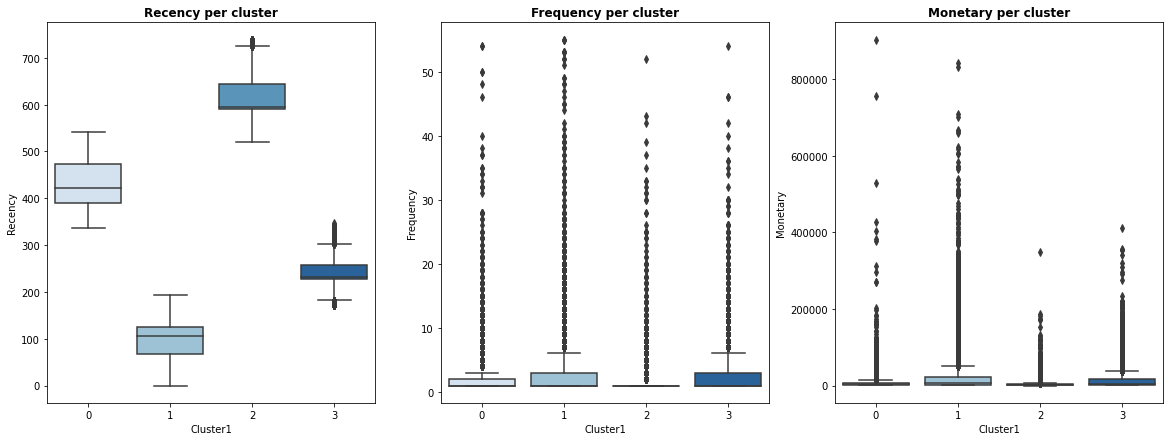

In [106]:
# Boxplots

colors = ['#08306B', '#08519C', '#2171B5', '#4292C6', '#6BAED6']

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
sns.boxplot(x = 'Cluster1', y='Recency', data=RFM_res, palette="Blues")

plt.ylabel('Recency')
plt.title('Recency per cluster', fontweight='bold')

plt.subplot(1,3,2)
sns.boxplot(x = 'Cluster1', y='Frequency', data=RFM_res, palette="Blues")

plt.ylabel('Frequency')
plt.title('Frequency per cluster', fontweight='bold')

plt.subplot(1,3,3)
sns.boxplot(x = 'Cluster1', y='Monetary', data=RFM_res, palette="Blues")

plt.ylabel('Monetary')
plt.title('Monetary per cluster', fontweight='bold');


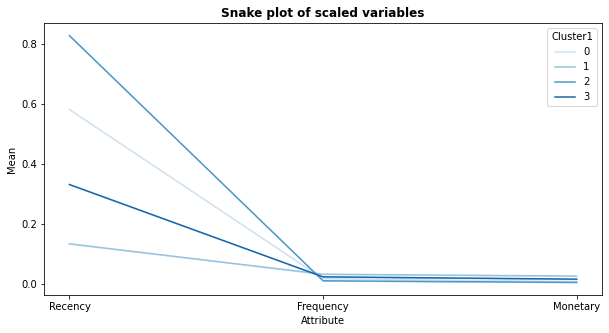

In [113]:
# Snake plot

# Snake plot
RFM_snake = pd.DataFrame(RFM,
                   columns=['Recency', 'Frequency', 'Monetary'])

RFM_res2=RFM_res.reset_index()
RFM_snake['Cluster1'] = RFM_res2['Cluster1']
RFM_snake['Customer ID'] = RFM_res2['Customer ID']

RFM_melt = pd.melt(RFM_snake,
                   id_vars=['Customer ID', 'Cluster1'],
                   value_vars=['Recency', 'Frequency', 'Monetary'],
                   var_name='Attribute',
                   value_name='Mean')

palette = sns.color_palette("Blues", 4)

plt.figure(figsize=(10,5))
plt.title('Snake plot of scaled variables', fontweight='bold')
sns.lineplot(x='Attribute', y='Mean', hue='Cluster1', data=RFM_melt, palette=palette);




In [ ]:
#silhouette score
silhouette_score(RFM,kmeans.labels_,metric="sqeuclidean")

0.7093971922069029

In [ ]:
######################
#model2: Relative Frequency
RFM=RFM_rel.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)

In [ ]:
######################
#model3: Frequency - StandardScaled
RFM=RFM_abs.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.StandardScaler().fit(RFM)
RFM=scaler.transform(RFM)

In [ ]:
######################
#model4: Relative Frequency - StandardScaled
RFM=RFM_rel.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.StandardScaler().fit(RFM)
RFM=scaler.transform(RFM)

In [ ]:
######################
#model5: Frequency - StandardScaled
RFM_abs2=RFM_abs.copy()
RFM_abs2['Recency'] = RFM_abs2['Recency'] + 1

RFM = np.log(RFM_abs2.drop('Customer ID', axis=1))
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)


In [ ]:
######################
#model6: Frequency - Logarithmic
RFM_abs2=RFM_abs.copy()
RFM_abs2['Recency'] = RFM_abs2['Recency'] + 1

RFM = np.log(RFM_abs2.drop('Customer ID', axis=1))
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)

In [ ]:
#####################
#model7: Lifetime
RFM_abs2= data[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Lifetime']].drop_duplicates()
RFM=RFM_abs2.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)



In [ ]:
#####################
#model8: Lifetime to model
RFM_abs2= data[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Lifetime']].drop_duplicates()
RFM_abs2['Recency'] = RFM_abs2['Recency'] + 1
RFM = np.log(RFM_abs2.drop('Customer ID', axis=1))
scaler=preprocessing.StandardScaler().fit(RFM)
RFM=scaler.transform(RFM)




In [45]:
#Final model
#customers with one purchase (for visualization reasons we excluded 326 customers with Monetary >30000)
RFM_abs1=RFM_abs[(RFM_abs["Frequency"]==1)& (RFM_abs["Monetary"]<=30000)]
RFM=RFM_abs1.copy().drop(["Customer ID","Frequency"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)


In [46]:
len(RFM_abs1)

39652

In [47]:
#Mean-shift
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth=estimate_bandwidth(RFM, quantile=0.16)
cluster=MeanShift(bandwidth=bandwidth)
cluster.fit(RFM)

MeanShift(bandwidth=0.1691049990642251)

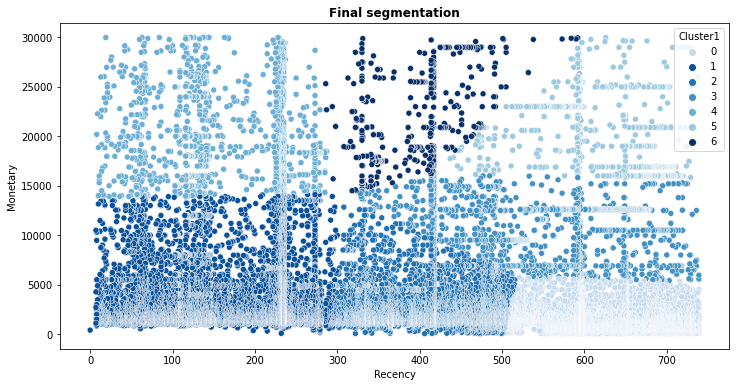

In [48]:
RFM_res = RFM_abs1.copy()
RFM_res['Cluster1'] =cluster.labels_
RFM_one=RFM_res.copy()
plt.figure(figsize=(12,6))

palette = sns.color_palette("Blues", 7)
colors = ['#08306B', '#08519C', '#2171B5', '#4292C6', '#6BAED6', '#9ECAE1','#C6DBEF']

colors = ['#C6DBEF', '#08519C', '#2171B5', '#4292C6', '#6BAED6', '#9ECAE1','#08306B']

plt.title('Final segmentation', fontweight='bold')
sns.scatterplot(RFM_res["Recency"],RFM_res["Monetary"], hue=RFM_res["Cluster1"], palette=colors);

In [49]:
#write final model to csv
#RFM_one.to_csv('/content/drive/MyDrive/Colab Notebooks/final_model.csv')

In [23]:
RFM_one = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_model.csv')
RFM_one

Unnamed: 0  Customer ID  Recency  Frequency  Monetary  Cluster1
0               0          1.0    739.0          1    1950.0         0
1               7          6.0    739.0          1     170.0         0
2              10          9.0    739.0          1    5500.0         3
3              11         10.0    739.0          1     366.0         0
4              38         22.0    739.0          1     740.0         0
...           ...          ...      ...        ...       ...       ...
39647      562236     112161.0      7.0          1    1099.0         1
39648      562281     111635.0      7.0          1    2690.0         1
39649      562288     110561.0      7.0          1   10500.0         1
39650      562323     111463.0      7.0          1    4265.0         1
39651      565157      40853.0      0.0          1     399.0         1

[39652 rows x 6 columns]

In [53]:
silhouette_score(RFM,cluster.labels_,metric="sqeuclidean")

0.6700236097960243

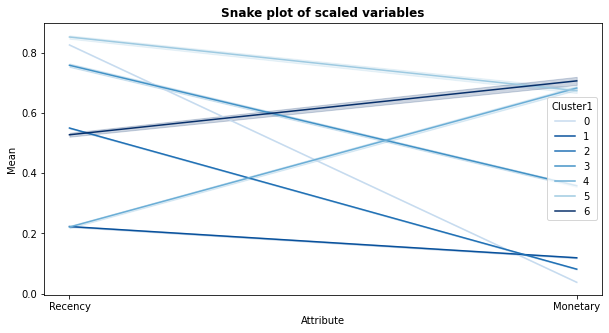

In [54]:
RFM_snake = pd.DataFrame(RFM,
                   columns=['Recency','Monetary'])

RFM_res=RFM_res.reset_index()
RFM_snake['Cluster1'] = RFM_res['Cluster1']
RFM_snake['Customer ID'] = RFM_res['Customer ID']

RFM_melt = pd.melt(RFM_snake,
                   id_vars=['Customer ID', 'Cluster1'],
                   value_vars=['Recency','Monetary'],
                   var_name='Attribute',
                   value_name='Mean')

plt.figure(figsize=(10,5))

colors = ['#C6DBEF', '#08519C', '#2171B5', '#4292C6', '#6BAED6', '#9ECAE1','#08306B']
plt.title('Snake plot of scaled variables', fontweight='bold')
sns.lineplot(x='Attribute', y='Mean', hue='Cluster1', data=RFM_melt, palette=colors);

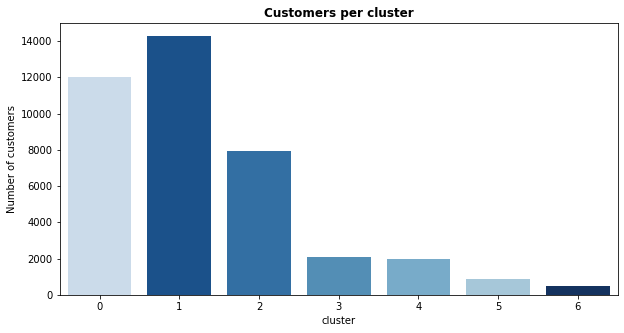

In [127]:
#size
plt.figure(figsize=(10,5))
sns.countplot(cluster.labels_, palette=colors)
plt.title("Customers per cluster", fontweight='bold')
plt.xlabel("cluster")
plt.ylabel("Number of customers");

In [55]:
# Recurring customers (for visualisation reasons 368 customers excluded)
RFM_abs1=RFM_abs[(RFM_abs["Frequency"]!=1)&(RFM_abs["Monetary"]<=250000)&(RFM_abs["Frequency"]<=20)]
RFM=RFM_abs1.copy().drop(["Customer ID"],axis=1)
scaler=preprocessing.MinMaxScaler().fit(RFM)
RFM=scaler.transform(RFM)


In [131]:
#size
len(RFM)

20539

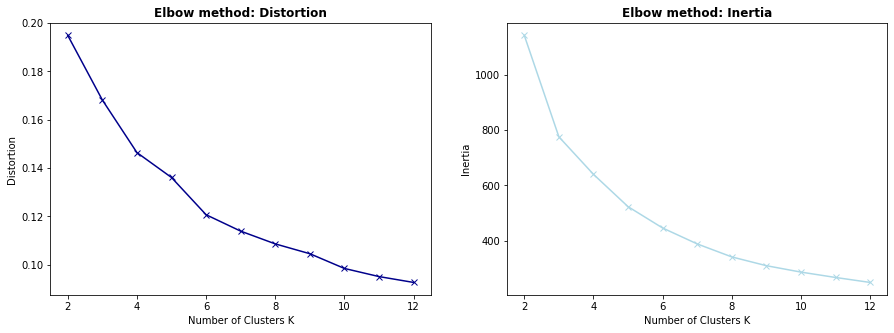

In [132]:
#Elbow
range_n_cluster = [2,3,4,5,6,7,8,9,10,11,12]
ssd = []
distortions = []
for i in range_n_cluster:
    kmeans = KMeans(n_clusters = i, random_state=seed)
    kmeans.fit(RFM)
    ssd.append(kmeans.inertia_)
    distortions.append(sum(np.min(cdist(RFM, kmeans.cluster_centers_, 'euclidean'), axis=1)) / np.size(RFM, axis = 0))

# Elbow: Plotting the distortion as a function of the number of clusters
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range_n_cluster, distortions, 'x-',  color='darkblue')
plt.xlabel('Number of Clusters K')
plt.ylabel('Distortion')
plt.title('Elbow method: Distortion', fontweight='bold');

plt.subplot(1,2,2)
plt.plot(range_n_cluster, ssd, 'x-',  color='lightblue')
plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.title('Elbow method: Inertia', fontweight='bold');

In [56]:
import plotly.express as px
# K-Mean
kmeans=KMeans(n_clusters=5, random_state = seed)
kmeans.fit(RFM)
# add now the predicted cluster to the RFM table
RFM_res = RFM_abs1.copy()
RFM_res['Cluster1'] = kmeans.labels_
RFM_rep=RFM_res

RFMp=RFM_res.drop(["Cluster1"],axis=1)
fig = px.scatter_3d(RFMp, x="Frequency", y="Monetary", z="Recency",labels=RFM_res["Cluster1"], color=RFM_res["Cluster1"])

fig = fig.update_traces(marker=dict(size=2,
                              line=dict(width=2,
                                        color=RFM_res["Cluster1"])),
                  selector=dict(mode='markers'))

fig.layout.showlegend = True
fig.show()


In [58]:
colors = ['#08306B', '#08519C', '#2171B5', '#4292C6', '#6BAED6']
fig = px.scatter_3d(RFM_res, x="Frequency", y="Monetary", z="Recency",labels="Cluster1",  width=1000,
    height=1000)

fig = fig.update_traces(marker=dict(size=3,
                                    line=dict(width=1),
                                    
                                    color=RFM_res["Cluster1"], 
                                    colorscale='Blues',
                                    ),
                        selector=dict(mode='markers'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
#fig.layout.showlegend = True
fig.show()

In [139]:
#Silhouette score
silhouette_score(RFM,kmeans.labels_,metric="sqeuclidean")

0.5751146375628305

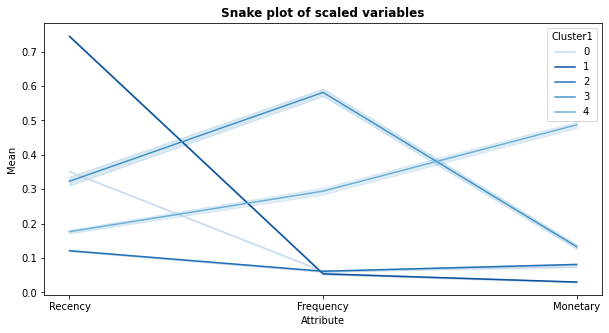

In [142]:
#Snake plot
RFM_snake = pd.DataFrame(RFM,
                   columns=['Recency','Frequency','Monetary'])

RFM_res2=RFM_res.reset_index()
RFM_snake['Cluster1'] = RFM_res2['Cluster1']
RFM_snake['Customer ID'] = RFM_res2['Customer ID']

RFM_melt = pd.melt(RFM_snake,
                   id_vars=['Customer ID', 'Cluster1'],
                   value_vars=['Recency','Frequency','Monetary'],
                   var_name='Attribute',
                   value_name='Mean')


plt.figure(figsize=(10,5))
colors = ['#C6DBEF', '#08519C', '#2171B5', '#4292C6', '#6BAED6']
plt.title('Snake plot of scaled variables', fontweight='bold')
sns.lineplot(x='Attribute', y='Mean', hue='Cluster1', data=RFM_melt, palette=colors);

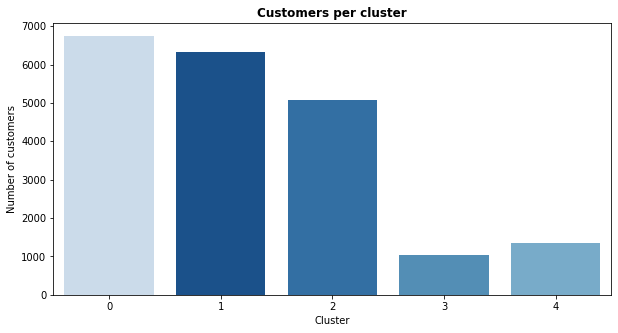

In [143]:
#sns.countplot(kmeans.labels_)
#plt.title("Customers per cluster")
#plt.xlabel("cluster")
#plt.ylabel("Number of customers");

plt.figure(figsize=(10,5))
sns.countplot(kmeans.labels_, palette=colors)
plt.title("Customers per cluster", fontweight='bold')
plt.xlabel("Cluster")
plt.ylabel("Number of customers");

## Chapter 4: Marketing Strategy 

In [59]:
# Proposal: Clusters for Marketing Activity 
# Cluster with low recency and/or high frequency as they tend to show higher likelihood to respond to marketing activities (see literature) 
# Additional cluster under focus with especially high monetary values as they are of special intrest/relevance for company

C1=RFM_one[RFM_one["Cluster1"]==1]
C2=RFM_one[RFM_one["Cluster1"]==4]
C3=RFM_one[(RFM_one["Cluster1"]==5)|(RFM_one["Cluster1"]==6)]
C4=RFM_rep[RFM_rep["Cluster1"]==2]
C5=RFM_rep[RFM_rep["Cluster1"]==3]
C6=RFM_rep[RFM_rep["Cluster1"]==4]

In [60]:
# 44% customer reach seems to be reasonable and cluster sizes not too small

print((len(C1)+len(C2)+len(C3))/len(RFM_one)*100)
print((len(C4)+len(C5)+len(C6))/len(RFM_rep)*100)
print((len(C1)+len(C2)+len(C3)+len(C4)+len(C5)+len(C6))/(len(RFM_one)+len(RFM_rep))*100)

print(len(C1))
print(len(C2))
print(len(C3))

print(len(C4))
print(len(C5))
print(len(C6))

44.416422879047715
36.29680120745898
41.64576099416856
14278
1966
1368
5065
1038
1352


In [61]:
#Sub-samples for each cluster
list1=[]
for id in data["Customer ID"]:
  list1.append(id in np.array(C1["Customer ID"]))
Sub1=data.loc[list1]

list2=[]
for id in data["Customer ID"]:
  list2.append(id in np.array(C2["Customer ID"]))
Sub2=data.loc[list2]

list3=[]
for id in data["Customer ID"]:
  list3.append(id in np.array(C3["Customer ID"]))
Sub3=data.loc[list3]

list4=[]
for id in data["Customer ID"]:
  list4.append(id in np.array(C4["Customer ID"]))
Sub4=data.loc[list4]

list5=[]
for id in data["Customer ID"]:
  list5.append(id in np.array(C5["Customer ID"]))
Sub5=data.loc[list5]

list6=[]
for id in data["Customer ID"]:
  list6.append(id in np.array(C6["Customer ID"]))
Sub6=data.loc[list6]

In [62]:
#Table overview

fill=np.zeros(shape=(6,8))
index=["Cluster1_onetime","Cluster4_onetime","Cluster5+6_onetime","Cluster2_repeat","Cluster3_repeat","Cluster4_repeat"]
overview=pd.DataFrame(fill,columns=["Rec. per Cust","Freq. per Cust","Monetary per Cust","Revenue per Order","Discount per Order ","Categories per Order ","Categories per Customer","Name"],index=index)

In [63]:
#Cluster 1
Average_Recency=C1["Recency"].mean()
Average_Frequency=C1["Frequency"].mean()
Average_Monetary=C1["Monetary"].mean()
group1=Sub1.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group1["grand_item"].mean()
Discount_per_Order= group1["discount_rate"].mean()
Categories_per_Order= group1["category_name_1"].mean()
group11=Sub1.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group11["category_name_1"].mean()

overview.iloc[0,0]= np.round(Average_Recency,1)
overview.iloc[0,1]= np.round(Average_Frequency,1)
overview.iloc[0,2]= np.round(Average_Monetary,1)
overview.iloc[0,3]= np.round(Revenue_per_Order,1)
overview.iloc[0,4]= np.round(Discount_per_Order,1)
overview.iloc[0,5]= np.round(Categories_per_Order,1)
overview.iloc[0,6]= np.round(Categories_per_Customer,1)

#Cluster 2
Average_Recency=C2["Recency"].mean()
Average_Frequency=C2["Frequency"].mean()
Average_Monetary=C2["Monetary"].mean()
group2=Sub2.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group2["grand_item"].mean()
Discount_per_Order= group2["discount_rate"].mean()
Categories_per_Order= group2["category_name_1"].mean()
group22=Sub2.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group22["category_name_1"].mean()

overview.iloc[1,0]= np.round(Average_Recency,1)
overview.iloc[1,1]= np.round(Average_Frequency,1)
overview.iloc[1,2]= np.round(Average_Monetary,1)
overview.iloc[1,3]= np.round(Revenue_per_Order,1)
overview.iloc[1,4]= np.round(Discount_per_Order,1)
overview.iloc[1,5]= np.round(Categories_per_Order,1)
overview.iloc[1,6]= np.round(Categories_per_Customer,1)

#Cluster 3
Average_Recency=C3["Recency"].mean()
Average_Frequency=C3["Frequency"].mean()
Average_Monetary=C3["Monetary"].mean()
group3=Sub3.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group3["grand_item"].mean()
Discount_per_Order= group3["discount_rate"].mean()
Categories_per_Order= group3["category_name_1"].mean()
group33=Sub3.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group33["category_name_1"].mean()

overview.iloc[2,0]= np.round(Average_Recency,1)
overview.iloc[2,1]= np.round(Average_Frequency,1)
overview.iloc[2,2]= np.round(Average_Monetary,1)
overview.iloc[2,3]= np.round(Revenue_per_Order,1)
overview.iloc[2,4]= np.round(Discount_per_Order,1)
overview.iloc[2,5]= np.round(Categories_per_Order,1)
overview.iloc[2,6]= np.round(Categories_per_Customer,1)

#Cluster 4
Average_Recency=C4["Recency"].mean()
Average_Frequency=C4["Frequency"].mean()
Average_Monetary=C4["Monetary"].mean()
group4=Sub4.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group4["grand_item"].mean()
Discount_per_Order= group4["discount_rate"].mean()
Categories_per_Order= group4["category_name_1"].mean()
group44=Sub4.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group44["category_name_1"].mean()

overview.iloc[3,0]= np.round(Average_Recency,1)
overview.iloc[3,1]= np.round(Average_Frequency,1)
overview.iloc[3,2]= np.round(Average_Monetary,1)
overview.iloc[3,3]= np.round(Revenue_per_Order,1)
overview.iloc[3,4]= np.round(Discount_per_Order,1)
overview.iloc[3,5]= np.round(Categories_per_Order,1)
overview.iloc[3,6]= np.round(Categories_per_Customer,1)

#Cluster 5
Average_Recency=C5["Recency"].mean()
Average_Frequency=C5["Frequency"].mean()
Average_Monetary=C5["Monetary"].mean()
group5=Sub5.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group5["grand_item"].mean()
Discount_per_Order= group5["discount_rate"].mean()
Categories_per_Order= group5["category_name_1"].mean()
group55=Sub5.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group55["category_name_1"].mean()

overview.iloc[4,0]= np.round(Average_Recency,1)
overview.iloc[4,1]= np.round(Average_Frequency,1)
overview.iloc[4,2]= np.round(Average_Monetary,1)
overview.iloc[4,3]= np.round(Revenue_per_Order,1)
overview.iloc[4,4]= np.round(Discount_per_Order,1)
overview.iloc[4,5]= np.round(Categories_per_Order,1)
overview.iloc[4,6]= np.round(Categories_per_Customer,1)

#Cluster 6
Average_Recency=C6["Recency"].mean()
Average_Frequency=C6["Frequency"].mean()
Average_Monetary=C6["Monetary"].mean()
group6=Sub6.groupby("increment_id").agg({"grand_item":"sum","discount_rate":"mean","item_id":"count","category_name_1":"nunique"})
Revenue_per_Order= group6["grand_item"].mean()
Discount_per_Order= group6["discount_rate"].mean()
Categories_per_Order= group6["category_name_1"].mean()
group66=Sub6.groupby("Customer ID").agg({"category_name_1":"nunique"})
Categories_per_Customer= group66["category_name_1"].mean()

overview.iloc[5,0]= np.round(Average_Recency,1)
overview.iloc[5,1]= np.round(Average_Frequency,1)
overview.iloc[5,2]= np.round(Average_Monetary,1)
overview.iloc[5,3]= np.round(Revenue_per_Order,1)
overview.iloc[5,4]= np.round(Discount_per_Order,1)
overview.iloc[5,5]= np.round(Categories_per_Order,1)
overview.iloc[5,6]= np.round(Categories_per_Customer,1)

overview.iloc[0,7]= "Up-seller"
overview.iloc[1,7]= "Keepers"
overview.iloc[2,7]= "Re-Activaters"
overview.iloc[3,7]= "Loyal-Shoppers"
overview.iloc[4,7]= "High-Potentials"
overview.iloc[5,7]= "Top Group"

overview



Rec. per Cust  Freq. per Cust  Monetary per Cust  \
Cluster1_onetime            164.6             1.0             3572.5   
Cluster4_onetime            163.3             1.0            20488.2   
Cluster5+6_onetime          547.1             1.0            20562.0   
Cluster2_repeat              95.6             3.1            20211.8   
Cluster3_repeat             243.5            12.5            33007.5   
Cluster4_repeat             136.1             7.3           121202.4   

                    Revenue per Order  Discount per Order   \
Cluster1_onetime               3572.5                  2.9   
Cluster4_onetime              20488.2                  6.6   
Cluster5+6_onetime            20562.0                  4.8   
Cluster2_repeat                6513.1                  6.2   
Cluster3_repeat                2647.5                  7.9   
Cluster4_repeat               16609.1                 13.0   

                    Categories per Order   Categories per Customer  \
Cluster1_onetime                      1.1                      1.1   
Cluster4_onetime                      1.0                      1.0   
Cluster5+6_onetime                    1.0                      1.0   
Cluster2_repeat                       1.1                      1.9   
Cluster3_repeat                       1.2                      5.4   
Cluster4_repeat                       1.0                      1.8   

                               Name  
Cluster1_onetime          Up-seller  
Cluster4_onetime            Keepers  
Cluster5+6_onetime    Re-Activaters  
Cluster2_repeat      Loyal-Shoppers  
Cluster3_repeat     High-Potentials  
Cluster4_repeat           Top Group

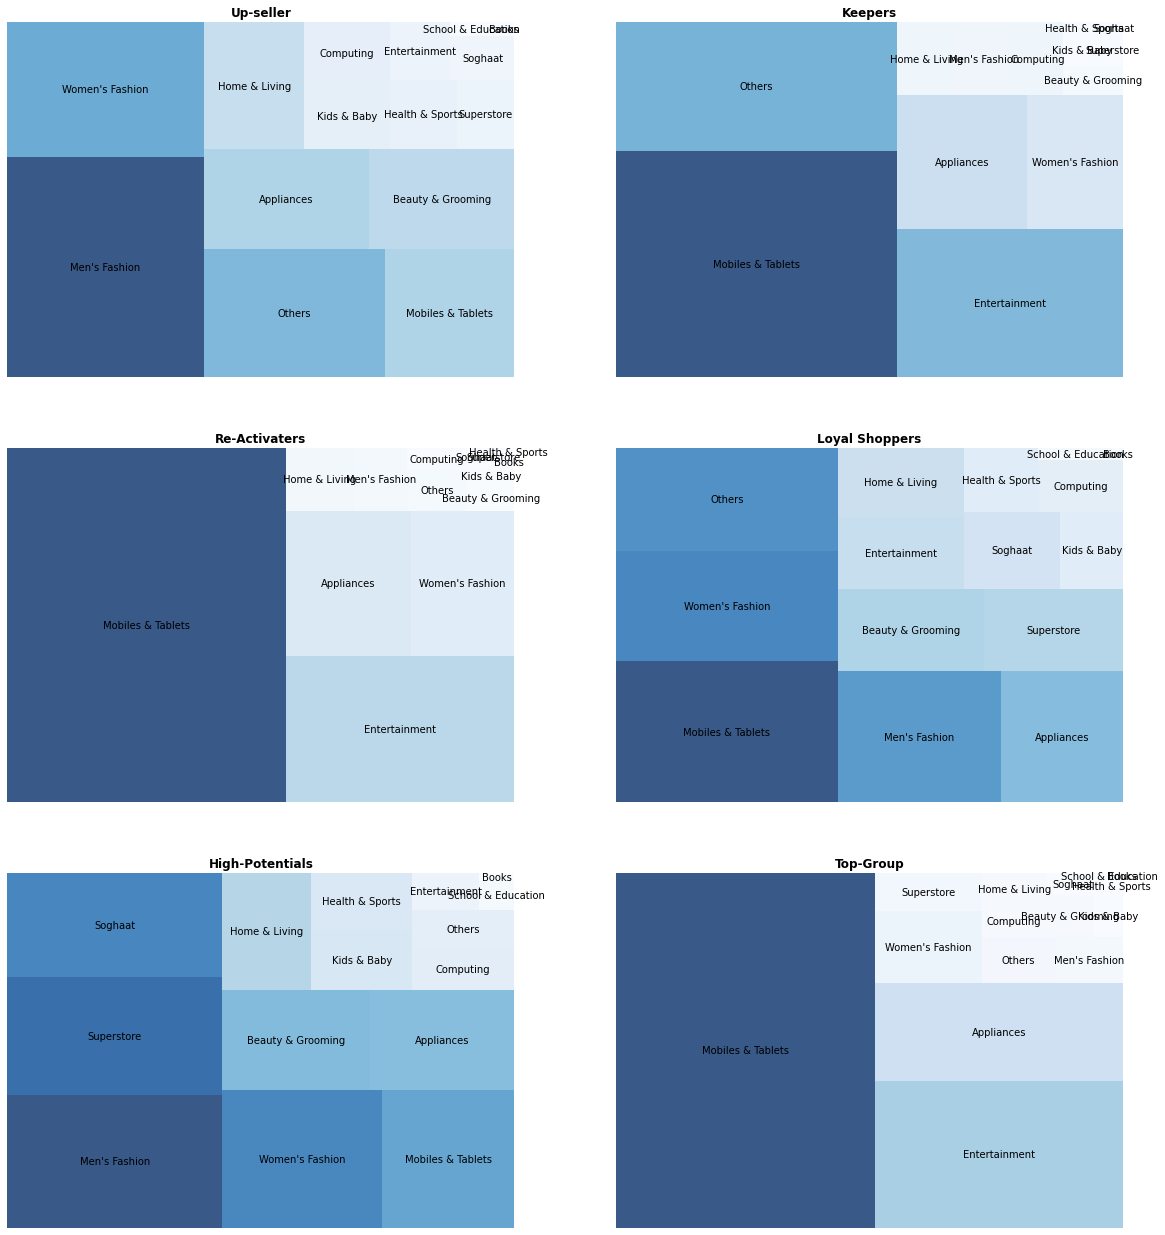

In [66]:
#offer strategy: categories per cluster


test1= pd.DataFrame(Sub1["category_name_1"].value_counts())
test1=test1.reset_index()

test2= pd.DataFrame(Sub2["category_name_1"].value_counts())
test2=test2.reset_index()

test3= pd.DataFrame(Sub3["category_name_1"].value_counts())
test3=test3.reset_index()

test4= pd.DataFrame(Sub4["category_name_1"].value_counts())
test4=test4.reset_index()

test5= pd.DataFrame(Sub5["category_name_1"].value_counts())
test5=test5.reset_index()

test6= pd.DataFrame(Sub6["category_name_1"].value_counts())
test6=test6.reset_index()



cmap = matplotlib.cm.Blues
mini=min(test1['category_name_1'])
maxi=max(test1['category_name_1'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in test1['category_name_1']]

plt.figure(figsize=(20,30))
plt.subplot(4,2,1)
squarify.plot(sizes=test1["category_name_1"], label=test1["index"], alpha=0.8 , color=colors)
plt.axis('off')
plt.title("Up-seller", fontweight='bold')




mini=min(test2['category_name_1'])
maxi=max(test2['category_name_1'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in test2['category_name_1']]

plt.subplot(4,2,2)
squarify.plot(sizes=test2["category_name_1"], label=test2["index"], alpha=0.8, color=colors )
plt.axis('off')
plt.title("Keepers", fontweight='bold')



mini=min(test3['category_name_1'])
maxi=max(test3['category_name_1'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in test3['category_name_1']]

plt.subplot(4,2,3)
squarify.plot(sizes=test3["category_name_1"], label=test3["index"], alpha=0.8, color=colors )
plt.axis('off')
plt.title("Re-Activaters", fontweight='bold')


mini=min(test4['category_name_1'])
maxi=max(test4['category_name_1'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in test4['category_name_1']]

plt.subplot(4,2,4)
squarify.plot(sizes=test4["category_name_1"], label=test4["index"], alpha=0.8, color=colors )
plt.axis('off')
plt.title("Loyal Shoppers", fontweight='bold');



mini=min(test5['category_name_1'])
maxi=max(test5['category_name_1'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in test5['category_name_1']]

plt.subplot(4,2,5)
squarify.plot(sizes=test5["category_name_1"], label=test5["index"], alpha=0.8, color=colors )
plt.axis('off')
plt.title("High-Potentials", fontweight='bold');


mini=min(test6['category_name_1'])
maxi=max(test6['category_name_1'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in test6['category_name_1']]

plt.subplot(4,2,6)
squarify.plot(sizes=test6["category_name_1"], label=test6["index"], alpha=0.8 , color=colors)
plt.axis('off')
plt.title("Top-Group", fontweight='bold');


In [67]:
#Reload data 

df2=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pakistan Largest Ecommerce Dataset.csv")
df2.dropna(axis=0,how='all',inplace=True)
df2.dropna(axis=1,how='all',inplace=True)
df2=df2.drop(["sales_commission_code"],axis=1)
df2=df2.dropna(axis=0,how="any")

df2['status_new'] = df2['status']
df2['status_new'] = df2['status_new'].replace(['order_refunded', 'refund'],'refunded')
df2['status_new'] = df2['status_new'].replace(['complete', 'closed'],'completed')
df2['status_new'] = df2['status_new'].replace(['paid','received','cod',"exchange"],'processing')
df2['status_new'] = df2['status_new'].replace(['holded','pending_paypal','payment_review'],'pending')

df2.category_name_1.fillna('\\N',inplace=True)
df2.category_name_1.replace('\\N',"Others",inplace=True)

df2['grand_item']=df2["price"]*df2["qty_ordered"] - df2["discount_amount"]
df2=df2[df2["price"]>0]
df2=df2[df2["grand_total"]>0]
df2=df2[df2["discount_amount"]>=0]
test2=df2.groupby(["increment_id"]).agg({"grand_item":"sum","grand_total":"mean","item_id":"count"})

test3=test2[test2["grand_item"] - test2["grand_total"]==0]

dele=[]
for incid in df2["increment_id"]:
  dele.append(incid in test3.index)

dft2=df2.loc[dele]
df2=dft2

df2['discount_rate'] = (df2['discount_amount']/(df2["price"]*df2["qty_ordered"])* 100).round(2)

df2["BI Status"]=df2["BI Status"].replace(to_replace=['#REF!'],value=["Net"])
df2['BIstatus_num'] = df2['BI Status']
df2['BIstatus_num'] = df2['BIstatus_num'].replace(['Net'], 1)
df2['BIstatus_num'] = df2['BIstatus_num'].replace(['Valid'], 0)
df2['BIstatus_num'] = df2['BIstatus_num'].replace(['Gross'], -1)


df2['payment_method'].replace(['Easypay_MA','easypay_voucher'],'Easypay',inplace=True)
df2['payment_method'].replace(['jazzwallet','jazzvoucher'],'Jazz',inplace=True)
df2['payment_method'].replace(['customercredit','ublcreditcard'],'Credit',inplace=True)
df2['payment_method'].replace(['internetbanking'],'bankalfalah',inplace=True)





In [ ]:
# share of completed per discount 

df2=df2[df2["status_new"]!="processing"]

Gd=df2.groupby(["increment_id"]).agg({"discount_rate":"mean","BIstatus_num":np.unique})
Gd["l"]=pd.cut(Gd["discount_rate"],bins=[-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
          labels=["l1","l2","l3","l4","l5","l6","l7","l8","l9","l10","l11","l12","l13","l14","l15","l16","l17","l18","l19","l20","l21"])
res=[]
for i in ["l1","l2","l3","l4","l5","l6","l7","l8","l9","l10","l11","l12","l13","l14","l15","l16","l17","l18","l19","l20","l21"]:
  a=len(Gd[(Gd["BIstatus_num"]==1)&(Gd["l"]==i)])/len(Gd[Gd["l"]==i])*100
  res.append(a)

Discount=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
Share_of_completed =res

fig = px.line(x=Discount,y=Share_of_completed)
fig.update_traces(mode="markers+lines", hovertemplate=None) 
fig.update_layout(hovermode="x unified")
fig.update_layout(height=600, width=800, title_text="Share of completed/closed orders per discount-level")
fig.update_xaxes(title_text="Discount-level")
fig.update_yaxes(title_text="Share of completed orders")
fig.show();

In [68]:
# share of completed per discount (category)

neu=['Appliances', 'Entertainment', "Men's Fashion", 'Mobiles & Tablets', 'Superstore', "Women's Fashion"]
neu2=[0, 1, 2, 3, 4, 5]

x=np.zeros(shape=(11,6))
for inte,word in zip(neu2, neu):
  dfx=
  [df2["category_name_1"]==word]
  Gd=dfx.groupby(["increment_id"]).agg({"discount_rate":"mean","BIstatus_num":np.unique})
  Gd["l"]=pd.cut(Gd["discount_rate"],bins=[-5,0,5,10,15,20,25,30,35,40,45,50],
          labels=["l1","l2","l3","l4","l5","l6","l7","l8","l9","l10","l11"])
  res=[]
  for i in ["l1","l2","l3","l4","l5","l6","l7","l8","l9","l10","l11"]:
    a=len(Gd[(Gd["BIstatus_num"]==1)&(Gd["l"]==i)])/(len(Gd[Gd["l"]==i])+0.1)*100
    res.append(a)
  x[:,inte]=res

In [79]:
from plotly.subplots import make_subplots
import plotly.graph_objects as gx
z=[0,5,10,15,20,25,30,35,40,45,50]

fig = make_subplots(rows=2, cols=3, 
subplot_titles=("Appliances","Entertainment","Men's Fashion","Mobiles & Tablets", "Superstore","Women's Fashion"),
shared_xaxes=True, shared_yaxes=True)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,0]),
    row=1, col=1
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,1]),
    row=1, col=2
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,2]),
    row=1, col=3
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,3]),
    row=2, col=1
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,4]),
    row=2, col=2
)

fig.add_trace(
    gx.Scatter(x=z, y=x[:,5]),
    row=2, col=3
)

fig.update_layout(height=600, width=1200, title_text="Share of completedorders per discount-level")
fig.show()

In [24]:
#Time Series Analysis

#Deep dive into the clusters of part 2, to get an idea which products we could push with marketing
#most interesstings groups are group 0 and 4. both have a short recency. additionaly look deeper into group 5 (heigher recnecy but also a high monetary score)

#create CSV which contains result of cluster 1
RFM_res_merged = data.merge(right=RFM_one.reset_index(),on='Customer ID',how='left')
#RFM_res_merged = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1.csv')
RFM_res_merged.head()

item_id    status created_at  \
0  211131.0  complete   7/1/2016   
1  211139.0  complete   7/1/2016   
2  211142.0  complete   7/1/2016   
3  211143.0  received   7/1/2016   
4  211144.0  received   7/1/2016   

                                                sku   price  qty_ordered  \
0                                 kreations_YI 06-L  1950.0          1.0   
1                      UK_Namkino Mix Nimco 400 Gms   170.0          1.0   
2  GFC_Pedestal Myga Cross Base (Special Guard) 24"  5500.0          1.0   
3                                       BK1070200PL   210.0          1.0   
4                                       BK1130200CF   156.0          1.0   

   grand_total increment_id  category_name_1  discount_amount  ...  \
0       1950.0    100147443  Women's Fashion              0.0  ...   
1        170.0    100147450          Soghaat              0.0  ...   
2       5500.0    100147453       Appliances              0.0  ...   
3        366.0    100147454          Soghaat              0.0  ...   
4        366.0    100147454          Soghaat              0.0  ...   

  Most_Recent_Purchase Recency_x Frequency_x Monetary_x  index  Unnamed: 0  \
0           2016-07-01     739.0           1     1950.0    0.0         0.0   
1           2016-07-01     739.0           1      170.0    1.0         7.0   
2           2016-07-01     739.0           1     5500.0    2.0        10.0   
3           2016-07-01     739.0           1      366.0    3.0        11.0   
4           2016-07-01     739.0           1      366.0    3.0        11.0   

  Recency_y Frequency_y Monetary_y  Cluster1  
0     739.0         1.0     1950.0       0.0  
1     739.0         1.0      170.0       0.0  
2     739.0         1.0     5500.0       3.0  
3     739.0         1.0      366.0       0.0  
4     739.0         1.0      366.0       0.0  

[5 rows x 40 columns]

In [25]:
# RFM_res_merged.to_csv("Result_Cluster1.csv",index=False)
RFM_res_merged.to_csv("/content/drive/MyDrive/Colab Notebooks/Result_Cluster1.csv",index=False)

# RFM_res_merged_TS = pd.read_csv('Result_Cluster1.csv', index_col=2, parse_dates=[2], squeeze=True)
RFM_res_merged_TS = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1.csv', index_col=2, parse_dates=[2], squeeze=True)

RFM_res_merged_TS.head(10)

item_id    status  \
created_at                       
2016-07-01  211131.0  complete   
2016-07-01  211139.0  complete   
2016-07-01  211142.0  complete   
2016-07-01  211143.0  received   
2016-07-01  211144.0  received   
2016-07-01  211145.0  complete   
2016-07-01  211155.0  complete   
2016-07-01  211156.0  complete   
2016-07-01  211166.0  complete   
2016-07-01  211174.0  complete   

                                                         sku   price  \
created_at                                                             
2016-07-01                                 kreations_YI 06-L  1950.0   
2016-07-01                      UK_Namkino Mix Nimco 400 Gms   170.0   
2016-07-01  GFC_Pedestal Myga Cross Base (Special Guard) 24"  5500.0   
2016-07-01                                       BK1070200PL   210.0   
2016-07-01                                       BK1130200CF   156.0   
2016-07-01                                      kcc_Sultanat   120.0   
2016-07-01                                         J&J_JJR-4   149.0   
2016-07-01                                        J&J_JJR-20   149.0   
2016-07-01                     Ctees-Black Zip- Up Hoodie-XL   450.0   
2016-07-01                                       JBS_TAT-128  3672.0   

            qty_ordered  grand_total increment_id  category_name_1  \
created_at                                                           
2016-07-01          1.0       1950.0    100147443  Women's Fashion   
2016-07-01          1.0        170.0    100147450          Soghaat   
2016-07-01          1.0       5500.0    100147453       Appliances   
2016-07-01          1.0        366.0    100147454          Soghaat   
2016-07-01          1.0        366.0    100147454          Soghaat   
2016-07-01          1.0        120.0    100147455    Home & Living   
2016-07-01          1.0        298.0    100147460      Kids & Baby   
2016-07-01          1.0        298.0    100147460      Kids & Baby   
2016-07-01          1.0        450.0    100147465      Kids & Baby   
2016-07-01          1.0       3672.0    100147470    Home & Living   

            discount_amount payment_method  ... Most_Recent_Purchase  \
created_at                                  ...                        
2016-07-01              0.0            cod  ...           2016-07-01   
2016-07-01              0.0            cod  ...           2016-07-01   
2016-07-01              0.0            cod  ...           2016-07-01   
2016-07-01              0.0            cod  ...           2016-07-01   
2016-07-01              0.0            cod  ...           2016-07-01   
2016-07-01              0.0         Credit  ...           2016-08-20   
2016-07-01              0.0            cod  ...           2017-07-14   
2016-07-01              0.0            cod  ...           2017-07-14   
2016-07-01              0.0            cod  ...           2016-11-22   
2016-07-01              0.0            cod  ...           2018-01-21   

           Recency_x Frequency_x  Monetary_x  index Unnamed: 0 Recency_y  \
created_at                                                                 
2016-07-01     739.0           1     1950.00    0.0        0.0     739.0   
2016-07-01     739.0           1      170.00    1.0        7.0     739.0   
2016-07-01     739.0           1     5500.00    2.0       10.0     739.0   
2016-07-01     739.0           1      366.00    3.0       11.0     739.0   
2016-07-01     739.0           1      366.00    3.0       11.0     739.0   
2016-07-01     689.0           3      780.00    NaN        NaN       NaN   
2016-07-01     361.0          10    17452.99    NaN        NaN       NaN   
2016-07-01     361.0          10    17452.99    NaN        NaN       NaN   
2016-07-01     595.0          10     5526.00    NaN        NaN       NaN   
2016-07-01     170.0          13    29416.40    NaN        NaN       NaN   

           Frequency_y  Monetary_y Cluster1  
created_at                                   
2016-07-01         1.0      

In [26]:
RFM_res_merged_Cluster0 = RFM_res_merged[RFM_res_merged['Cluster1']==1]
RFM_res_merged_Cluster4 = RFM_res_merged[RFM_res_merged['Cluster1']==4]
RFM_res_merged_Cluster5 = RFM_res_merged[(RFM_res_merged['Cluster1']==5) | (RFM_res_merged['Cluster1']==6)]


#build dataset which contains only data of group 1,4,5,6 and investigate data in a time series analysis
RFM_res_merged_Cluster_TS = RFM_res_merged_TS[(RFM_res_merged_TS['Cluster1']==1) | (RFM_res_merged_TS['Cluster1']==4) | (RFM_res_merged_TS['Cluster1']==5) | (RFM_res_merged_TS['Cluster1']==6) ]

RFM_res_merged_Cluster_TS_1 = RFM_res_merged_Cluster_TS['Frequency_x']

In [64]:
import plotly.express as px
RFM_res_merged_Cluster_TS_count = RFM_res_merged_Cluster_TS.groupby(['created_at', 'Cluster1']).agg('count')
RFM_res_merged_Cluster_TS_count = RFM_res_merged_Cluster_TS_count.reset_index()
RFM_res_merged_Cluster_TS_count


'#08306B', '#08519C', '#2171B5', '#4292C6',

fig = px.line(RFM_res_merged_Cluster_TS_count, x='created_at', y='item_id', color='Cluster1', 
              color_discrete_map={ 1: "#395989", 4: "#5A9ACA", 5: "#8CC0DF", 6:"grey"},
              labels={
                     "item_id": "Transactions per day",
                     "created_at": "Order date",
                     "Cluster1": "Target groups"},
              title='<b>Count transactions per day - separated by target groups (1,4,5,6) - One time customer</b>',
              height=500, width=1000)
#fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [57]:
RFM_res_merged = data.merge(right=RFM_rep.reset_index(),on='Customer ID',how='left')

In [58]:
# do the same analysis on the second group - they bought more than one times

RFM_res_merged = data.merge(right=RFM_rep.reset_index(),on='Customer ID',how='left')

# RFM_res_merged.to_csv("Result_Cluster1_3d.csv",index=False)
RFM_res_merged.to_csv("/content/drive/MyDrive/Colab Notebooks/Result_Cluster1_3d.csv",index=False)

# RFM_res_merged_3d_TS = pd.read_csv('Result_Cluster1_3d.csv', index_col=2, parse_dates=[2], squeeze=True)
RFM_res_merged_3d_TS = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1_3d.csv', index_col=2, parse_dates=[2], squeeze=True)

RFM_res_merged_3d_TS.head()

#RFM_res_merged_TS = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Result_Cluster1_3d.csv', index_col=2, parse_dates=[2], squeeze=True)

#RFM_res_merged_3d_TS = data.merge(right=RFM_res_merged_TS.reset_index(),on='Customer ID',how='left')
#RFM_res_merged_3d_TS.head()

item_id    status  \
created_at                       
2016-07-01  211131.0  complete   
2016-07-01  211139.0  complete   
2016-07-01  211142.0  complete   
2016-07-01  211143.0  received   
2016-07-01  211144.0  received   

                                                         sku   price  \
created_at                                                             
2016-07-01                                 kreations_YI 06-L  1950.0   
2016-07-01                      UK_Namkino Mix Nimco 400 Gms   170.0   
2016-07-01  GFC_Pedestal Myga Cross Base (Special Guard) 24"  5500.0   
2016-07-01                                       BK1070200PL   210.0   
2016-07-01                                       BK1130200CF   156.0   

            qty_ordered  grand_total increment_id  category_name_1  \
created_at                                                           
2016-07-01          1.0       1950.0    100147443  Women's Fashion   
2016-07-01          1.0        170.0    100147450          Soghaat   
2016-07-01          1.0       5500.0    100147453       Appliances   
2016-07-01          1.0        366.0    100147454          Soghaat   
2016-07-01          1.0        366.0    100147454          Soghaat   

            discount_amount payment_method  ... Lifetime Most_Recent_Purchase  \
created_at                                  ...                                 
2016-07-01              0.0            cod  ...    777.0           2016-07-01   
2016-07-01              0.0            cod  ...    777.0           2016-07-01   
2016-07-01              0.0            cod  ...    777.0           2016-07-01   
2016-07-01              0.0            cod  ...    777.0           2016-07-01   
2016-07-01              0.0            cod  ...    777.0           2016-07-01   

           Recency_x  Frequency_x  Monetary_x index Recency_y Frequency_y  \
created_at                                                                  
2016-07-01     739.0            1      1950.0   NaN       NaN         NaN   
2016-07-01     739.0            1       170.0   NaN       NaN         NaN   
2016-07-01     739.0            1      5500.0   NaN       NaN         NaN   
2016-07-01     739.0            1       366.0   NaN       NaN         NaN   
2016-07-01     739.0            1       366.0   NaN       NaN         NaN   

            Monetary_y Cluster1  
created_at                       
2016-07-01         NaN      NaN  
2016-07-01         NaN      NaN  
2016-07-01         NaN      NaN  
2016-07-01         NaN      NaN  
2016-07-01         NaN      NaN  

[5 rows x 38 columns]

In [59]:
RFM_res_merged_3d_TS = RFM_res_merged_3d_TS[(RFM_res_merged_3d_TS['Cluster1']==2) | (RFM_res_merged_3d_TS['Cluster1']==3) | (RFM_res_merged_3d_TS['Cluster1']==4) ]

RFM_res_merged_3d_TS_count = RFM_res_merged_3d_TS.groupby(['created_at', 'Cluster1']).agg('count')
RFM_res_merged_3d_TS_count = RFM_res_merged_3d_TS_count.reset_index()
RFM_res_merged_3d_TS_count['created_at'] = pd.to_datetime(RFM_res_merged_3d_TS_count['created_at'])
RFM_res_merged_3d_TS_count = RFM_res_merged_3d_TS_count.sort_values(by='created_at')

RFM_res_merged_3d_TS_count.head(5)


created_at  Cluster1  item_id  status  sku  price  qty_ordered  grand_total  \
0 2016-07-01       2.0        1       1    1      1            1            1   
1 2016-07-01       3.0       11      11   11     11           11           11   
2 2016-07-02       2.0        2       2    2      2            2            2   
3 2016-07-02       3.0        7       7    7      7            7            7   
4 2016-07-03       3.0       11      11   11     11           11           11   

   increment_id  category_name_1  ...  Customer_Since_Date  Lifetime  \
0             1                1  ...                    1         1   
1            11               11  ...                   11        11   
2             2                2  ...                    2         2   
3             7                7  ...                    7         7   
4            11               11  ...                   11        11   

   Most_Recent_Purchase  Recency_x  Frequency_x  Monetary_x  index  Recency_y  \
0                     1          1            1           1      1          1   
1                    11         11           11          11     11         11   
2                     2          2            2           2      2          2   
3                     7          7            7           7      7          7   
4                    11         11           11          11     11         11   

   Frequency_y  Monetary_y  
0            1           1  
1           11          11  
2            2           2  
3            7           7  
4           11          11  

[5 rows x 39 columns]

In [65]:
fig = px.line(RFM_res_merged_3d_TS_count, x='created_at', y='item_id', color='Cluster1', 
              title='<b>Count transactions per day - separated by target groups (2,3,4) - recurring customer</b>',
              color_discrete_map={ 2: "#395989", 3: "grey", 4: "#8CC0DF"},
              labels={
                     "item_id": "Transactions per day",
                     "created_at": "Order date",
                     "Cluster1": "Target groups"}, 
              height=500, width=1000)
#fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

RFM_res_merged_Cluster_TS_count_2 = RFM_res_merged_Cluster_TS.groupby('created_at').count()
RFM_res_merged_Cluster_TS_count_2 = RFM_res_merged_Cluster_TS_count_2.reset_index()

RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS
RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS_mean_discount_rate.reset_index()
RFM_res_merged_Cluster_TS_mean_discount_rate =RFM_res_merged_Cluster_TS_mean_discount_rate.groupby(['created_at'])['discount_rate'].mean()

RFM_res_merged_Cluster_TS_mean_discount_rate = RFM_res_merged_Cluster_TS_mean_discount_rate.reset_index()
RFM_res_merged_Cluster_TS_mean_discount_rate[RFM_res_merged_Cluster_TS_mean_discount_rate['created_at']=='2018-03-18']
RFM_res_merged_Cluster_TS_mean_discount_rate


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add traces
fig.add_trace(
    go.Scatter(x=RFM_res_merged_Cluster_TS_count_2['created_at'], y=RFM_res_merged_Cluster_TS_count_2['item_id'], name="Overall transactions per day"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=RFM_res_merged_Cluster_TS_mean_discount_rate['created_at'],y=RFM_res_merged_Cluster_TS_mean_discount_rate['discount_rate'], name="Mean Discount rate per day"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="<b>Overall transactions (Groups 0,4,5,6) vs Average Discount Rate - One Time Customer</b>"
)

# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Transactions</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Mean discount rate</b>", secondary_y=True)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

In [ ]:
# start hier with analysis of recurring customers

RFM_res_merged_3d_TS = RFM_res_merged_3d_TS[(RFM_res_merged_3d_TS['Cluster1']==2) | (RFM_res_merged_3d_TS['Cluster1']==3) | (RFM_res_merged_3d_TS['Cluster1']==4) ]

RFM_res_merged_3d_TS_count_2 = RFM_res_merged_3d_TS.groupby('created_at').count()
RFM_res_merged_3d_TS_count_2 = RFM_res_merged_3d_TS_count_2.reset_index()

RFM_res_merged_3d_TS_count_2['created_at'] = pd.to_datetime(RFM_res_merged_3d_TS_count_2['created_at'])
RFM_res_merged_3d_TS_count_2 = RFM_res_merged_3d_TS_count_2.sort_values(by='created_at')




RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS
RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS_mean_discount_rate.reset_index()
RFM_res_merged_3d_TS_mean_discount_rate =RFM_res_merged_3d_TS_mean_discount_rate.groupby(['created_at'])['discount_rate'].mean()

RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS_mean_discount_rate.reset_index()

RFM_res_merged_3d_TS_mean_discount_rate['created_at'] = pd.to_datetime(RFM_res_merged_3d_TS_mean_discount_rate['created_at'])
RFM_res_merged_3d_TS_mean_discount_rate = RFM_res_merged_3d_TS_mean_discount_rate.sort_values(by='created_at')

#RFM_res_merged_3d_TS_mean_discount_rate[RFM_res_merged_3d_TS_mean_discount_rate['created_at']=='2018-03-18']

#RFM_res_merged_3d_TS_count_2

# # Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add traces
fig.add_trace(
    go.Scatter(x=RFM_res_merged_3d_TS_count_2['created_at'], y=RFM_res_merged_3d_TS_count_2['item_id'], name="Overall transactions per day"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=RFM_res_merged_3d_TS_mean_discount_rate['created_at'],y=RFM_res_merged_3d_TS_mean_discount_rate['discount_rate'], name="Mean Discount rate per day"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="<b>Overall transactions (Groups 2,3,4) vs Average Discount Rate (Recurring Customers)</b>"
)

# Set x-axis title
fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Transactions</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Mean discount rate</b>", secondary_y=True)

fig.update_xaxes(rangeslider_visible=True)

fig.show()